**Chapter 11 – Deep Learning**

DNN challenge:

* First, `vanishing gradients` problem (or the related exploding gradients problem) that affects deep neural networks and makes lower layers very hard to train.
* Second, with such a large network, training would be extremely `slow`.
* Third, a model with millions of parameters would severely risk `overfitting` the training set.

## for gradient problem
* to reduce vanishing gradients: sigmoid(logistic activation func) will sacture, so ReLU is introduced, with subsidings leakyReLU, ELU, SELU(currently the best)
* to guarantee: use batch normalization to zero-center and normalize the inputs, before activition function.
* exploding gradients: clip gradient by threshold\

## for training accelaration
many methods could be used, mostly Adam is choosed.

## to avoid overfitting

* use L1/L2 regularization for weights during training
* use Dropout
* Max-Norm for weights
* data augmentation

## transfer learning
* freeze lower layers
* cache: calculate freezed layers outputs once and reuse
* unsupervisored pretraining, using autoencoders
* pretraining on an Auxiliary Task, often with 2 DNN, and reuse first DNN's lower layers. 

_This notebook contains all the sample code and solutions to the exercises in chapter 11._

# Setup

First, let's make sure this notebook works well in both python 2 and 3, import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures:

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "deep"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

# Vanishing/Exploding Gradients Problem

Looking at the logistic activation function (see Figure 11-1), you can see that when inputs become large (negative or positive), the function saturates at 0 or 1, with a derivative extremely close to 0. 

In [2]:
def logit(z):
    return 1 / (1 + np.exp(-z))

Saving figure sigmoid_saturation_plot


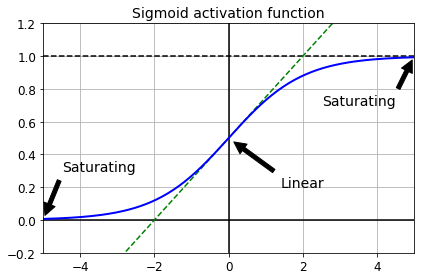

In [3]:
z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, logit(z), "b-", linewidth=2)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("Sigmoid activation function", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

save_fig("sigmoid_saturation_plot")
plt.show()

## Xavier and He Initialization

the authors argue that we need the variance of the outputs of each layer to be equal to the variance of its inputs, `fan-in and fan-out`

Note: the book uses `tensorflow.contrib.layers.fully_connected()` rather than `tf.layers.dense()` (which did not exist when this chapter was written). It is now preferable to use `tf.layers.dense()`, because anything in the contrib module may change or be deleted without notice. The `dense()` function is almost identical to the `fully_connected()` function. The main differences relevant to this chapter are:
* several parameters are renamed: `scope` becomes `name`, `activation_fn` becomes `activation` (and similarly the `_fn` suffix is removed from other parameters such as `normalizer_fn`), `weights_initializer` becomes `kernel_initializer`, etc.
* the default `activation` is now `None` rather than `tf.nn.relu`.
* it does not support `tensorflow.contrib.framework.arg_scope()` (introduced later in chapter 11).
* it does not support regularizer params (introduced later in chapter 11).

In [4]:
import tensorflow as tf

In [5]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

In [6]:
# use he initializer in dense layer
he_init = tf.contrib.layers.variance_scaling_initializer()
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu,
                          kernel_initializer=he_init, name="hidden1")

## Nonsaturating Activation Functions

ReLU activation function does not saturate for positive values, but it is not perfect. It suffers from a problem known as the dying ReLUs

To solve this problem, you may want to use a variant of the ReLU function, such as the leaky ReLU. This function is defined as LeakyReLUα(z) = max(αz, z) (see Figure 11-2).

### Leaky ReLU

In [10]:
def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)

Saving figure leaky_relu_plot


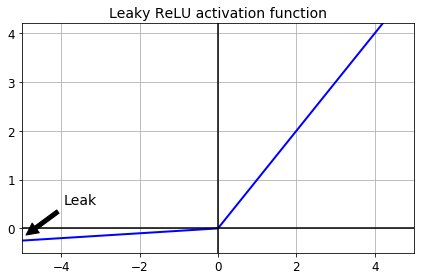

In [11]:
plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])

save_fig("leaky_relu_plot")
plt.show()

Implementing Leaky ReLU in TensorFlow:

In [12]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

In [13]:
def leaky_relu(z, name=None):
    return tf.maximum(0.01 * z, z, name=name)

hidden1 = tf.layers.dense(X, n_hidden1, activation=leaky_relu, name="hidden1")

Let's train a neural network on MNIST using the Leaky ReLU. First let's create the graph:

In [14]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

In [15]:
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

In [16]:
with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=leaky_relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=leaky_relu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

In [17]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

In [18]:
learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

In [19]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [20]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

Let's load the data:

In [21]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/")

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [22]:
n_epochs = 40
batch_size = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if epoch % 5 == 0:
            acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
            acc_test = accuracy.eval(feed_dict={X: mnist.validation.images, y: mnist.validation.labels})
            print(epoch, "Batch accuracy:", acc_train, "Validation accuracy:", acc_test)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Batch accuracy: 0.86 Validation accuracy: 0.9044
5 Batch accuracy: 0.94 Validation accuracy: 0.951
10 Batch accuracy: 0.96 Validation accuracy: 0.9666
15 Batch accuracy: 1.0 Validation accuracy: 0.9722
20 Batch accuracy: 1.0 Validation accuracy: 0.9748
25 Batch accuracy: 1.0 Validation accuracy: 0.9768
30 Batch accuracy: 0.98 Validation accuracy: 0.9778
35 Batch accuracy: 0.96 Validation accuracy: 0.9796


### ELU

a 2015 paper proposed ELU(exponential linear unit).
Its main drawback is slower.

In [25]:
def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

Saving figure elu_plot


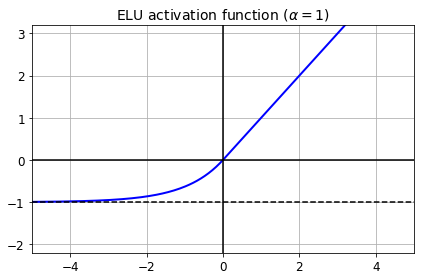

In [26]:
plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

save_fig("elu_plot")
plt.show()

Implementing ELU in TensorFlow is trivial, just specify the activation function when building each layer:
use `tf.nn.elu`

In [27]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.elu, name="hidden1")

### SELU
scaled elu

This activation function was proposed in this [great paper](https://arxiv.org/pdf/1706.02515.pdf) by Günter Klambauer, Thomas Unterthiner and Andreas Mayr, published in `June 2017` (I will definitely add it to the book). It outperforms the other activation functions very significantly for deep neural networks, so you should really try it out.

In [29]:
def selu(z,
         scale=1.0507009873554804934193349852946,
         alpha=1.6732632423543772848170429916717):
    return scale * elu(z, alpha)

Saving figure selu_plot


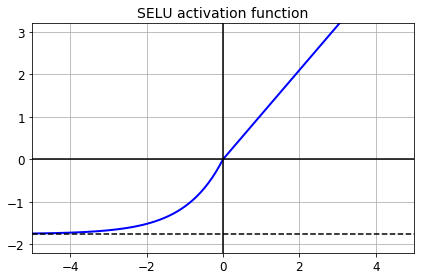

In [30]:
plt.plot(z, selu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1.758, -1.758], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"SELU activation function", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

save_fig("selu_plot")
plt.show()

With this activation function, even a 100 layer deep neural network preserves roughly mean 0 and standard deviation 1 across all layers, avoiding the exploding/vanishing gradients problem:

In [31]:
np.random.seed(42)
Z = np.random.normal(size=(500, 100))
for layer in range(100):
    W = np.random.normal(size=(100, 100), scale=np.sqrt(1/100))
    Z = selu(np.dot(Z, W))
    means = np.mean(Z, axis=1)
    stds = np.std(Z, axis=1)
    if layer % 10 == 0:
        print("Layer {}: {:.2f} < mean < {:.2f}, {:.2f} < std deviation < {:.2f}".format(
            layer, means.min(), means.max(), stds.min(), stds.max()))

Layer 0: -0.26 < mean < 0.27, 0.74 < std deviation < 1.27
Layer 10: -0.24 < mean < 0.27, 0.74 < std deviation < 1.27
Layer 20: -0.17 < mean < 0.18, 0.74 < std deviation < 1.24
Layer 30: -0.27 < mean < 0.24, 0.78 < std deviation < 1.20
Layer 40: -0.38 < mean < 0.39, 0.74 < std deviation < 1.25
Layer 50: -0.27 < mean < 0.31, 0.73 < std deviation < 1.27
Layer 60: -0.26 < mean < 0.43, 0.74 < std deviation < 1.35
Layer 70: -0.19 < mean < 0.21, 0.75 < std deviation < 1.21
Layer 80: -0.18 < mean < 0.16, 0.72 < std deviation < 1.19
Layer 90: -0.19 < mean < 0.16, 0.75 < std deviation < 1.20


Here's a TensorFlow implementation (there will almost certainly be a `tf.nn.selu()` function in future TensorFlow versions):

In [32]:
def selu(z,
         scale=1.0507009873554804934193349852946,
         alpha=1.6732632423543772848170429916717):
    return scale * tf.where(z >= 0.0, z, alpha * tf.nn.elu(z))

SELUs can also be combined with dropout, check out [this implementation](https://github.com/bioinf-jku/SNNs/blob/master/selu.py) by the Institute of Bioinformatics, Johannes Kepler University Linz.

Let's create a neural net for MNIST using the SELU activation function:

In [33]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=selu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=selu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
saver = tf.train.Saver()
n_epochs = 40
batch_size = 50

Now let's train it. Do not forget to scale the inputs to mean 0 and standard deviation 1:

In [34]:
means = mnist.train.images.mean(axis=0, keepdims=True)
stds = mnist.train.images.std(axis=0, keepdims=True) + 1e-10

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            X_batch_scaled = (X_batch - means) / stds
            sess.run(training_op, feed_dict={X: X_batch_scaled, y: y_batch})
        if epoch % 5 == 0:
            acc_train = accuracy.eval(feed_dict={X: X_batch_scaled, y: y_batch})
            X_val_scaled = (mnist.validation.images - means) / stds
            acc_test = accuracy.eval(feed_dict={X: X_val_scaled, y: mnist.validation.labels})
            print(epoch, "Batch accuracy:", acc_train, "Validation accuracy:", acc_test)

    save_path = saver.save(sess, "./my_model_final_selu.ckpt")

0 Batch accuracy: 0.96 Validation accuracy: 0.924
5 Batch accuracy: 1.0 Validation accuracy: 0.957
10 Batch accuracy: 0.94 Validation accuracy: 0.967
15 Batch accuracy: 0.98 Validation accuracy: 0.9682
20 Batch accuracy: 1.0 Validation accuracy: 0.9708
25 Batch accuracy: 1.0 Validation accuracy: 0.969
30 Batch accuracy: 1.0 Validation accuracy: 0.9698
35 Batch accuracy: 1.0 Validation accuracy: 0.9708


# Batch Normalization

Although using He initialization along with ELU (or any variant of ReLU) can significantly reduce the vanishing/exploding gradients problems at the beginning of training, it doesn’t guarantee that they won’t come back during training.

In a 2015 paper,7 Sergey Ioffe and Christian Szegedy proposed a technique called Batch Normalization (BN) to address the vanishing/exploding gradients problems, and more generally the problem that the distribution of each layer’s inputs changes during training, as the parameters of the previous layers change (which they call the Internal Covariate Shift problem).

The technique consists of adding an operation in the model just before the activation function of each layer, simply zero-centering and normalizing the inputs, then scaling and shifting the result using two new parameters per layer (one for scaling, the other for shifting). In other words, this operation lets the model learn the optimal scale and mean of the inputs for each layer.

At test time, there is no mini-batch to compute the empirical mean and standard deviation, so instead you simply use the whole training set’s mean and standard deviation.

Batch Normalization also acts like a regularizer, reducing the need for other regularization techniques (such as dropout, described later in the chapter).

Batch Normalization does, however, add some complexity to the model, and there is a runtime penalty.

Note: the book uses `tensorflow.contrib.layers.batch_norm()` rather than `tf.layers.batch_normalization()` (which did not exist when this chapter was written). It is now preferable to use `tf.layers.batch_normalization()`, because anything in the contrib module may change or be deleted without notice. Instead of using the `batch_norm()` function as a regularizer parameter to the `fully_connected()` function, we now use `batch_normalization()` and we explicitly create a distinct layer. The parameters are a bit different, in particular:
* `decay` is renamed to `momentum`,
* `is_training` is renamed to `training`,
* `updates_collections` is removed: the update operations needed by batch normalization are added to the `UPDATE_OPS` collection and you need to explicity run these operations during training (see the execution phase below),
* we don't need to specify `scale=True`, as that is the default.

Also note that in order to run batch norm just _before_ each hidden layer's activation function, we apply the ELU activation function manually, right after the batch norm layer.

Note: since the `tf.layers.dense()` function is incompatible with `tf.contrib.layers.arg_scope()` (which is used in the book), we now use python's `functools.partial()` function instead. It makes it easy to create a `my_dense_layer()` function that just calls `tf.layers.dense()` with the desired parameters automatically set (unless they are overridden when calling `my_dense_layer()`). As you can see, the code remains very similar.

In [39]:
reset_graph()

import tensorflow as tf

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

training = tf.placeholder_with_default(False, shape=(), name='training')

hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1")
bn1 = tf.layers.batch_normalization(hidden1, training=training, momentum=0.9)
bn1_act = tf.nn.elu(bn1)

hidden2 = tf.layers.dense(bn1_act, n_hidden2, name="hidden2")
bn2 = tf.layers.batch_normalization(hidden2, training=training, momentum=0.9)
bn2_act = tf.nn.elu(bn2)

logits_before_bn = tf.layers.dense(bn2_act, n_outputs, name="outputs")
logits = tf.layers.batch_normalization(logits_before_bn, training=training,
                                       momentum=0.9)

To avoid repeating the same parameters over and over again, we can use Python's `partial()` function:

In [53]:
from functools import partial

reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
training = tf.placeholder_with_default(False, shape=(), name='training')

my_batch_norm_layer = partial(tf.layers.batch_normalization,
                              training=training, momentum=0.9)

hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1")
bn1 = my_batch_norm_layer(hidden1)
bn1_act = tf.nn.elu(bn1)
hidden2 = tf.layers.dense(bn1_act, n_hidden2, name="hidden2")
bn2 = my_batch_norm_layer(hidden2)
bn2_act = tf.nn.elu(bn2)
logits_before_bn = tf.layers.dense(bn2_act, n_outputs, name="outputs")
logits = my_batch_norm_layer(logits_before_bn)

Let's build a neural net for MNIST, using the ELU activation function and Batch Normalization at each layer:

In [57]:
reset_graph()

batch_norm_momentum = 0.9

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")
training = tf.placeholder_with_default(False, shape=(), name='training')

with tf.name_scope("dnn"):
    he_init = tf.contrib.layers.variance_scaling_initializer()
    my_dense_layer = partial(
            tf.layers.dense,
            kernel_initializer=he_init)
    my_batch_norm_layer = partial(
            tf.layers.batch_normalization,
            training=training,
            momentum=batch_norm_momentum)

    hidden1 = my_dense_layer(X, n_hidden1, name="hidden1")
    bn1 = tf.nn.elu(my_batch_norm_layer(hidden1))
    
    hidden2 = my_dense_layer(bn1, n_hidden2, name="hidden2")
    bn2 = tf.nn.elu(my_batch_norm_layer(hidden2))
    
    logits_before_bn = my_dense_layer(bn2, n_outputs, name="outputs")
    logits = my_batch_norm_layer(logits_before_bn)

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

Note: since we are using `tf.layers.batch_normalization()` rather than `tf.contrib.layers.batch_norm()` (as in the book), we need to explicitly run the extra update operations needed by batch normalization (`sess.run([training_op, extra_update_ops],...`).

In [55]:
n_epochs = 20
batch_size = 200

In [56]:
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run([training_op, extra_update_ops],
                     feed_dict={training: True, X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images,
                                                y: mnist.test.labels})
        print(epoch, "Test accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Test accuracy: 0.8666
1 Test accuracy: 0.8951
2 Test accuracy: 0.9136
3 Test accuracy: 0.9222
4 Test accuracy: 0.9294
5 Test accuracy: 0.9337
6 Test accuracy: 0.9367
7 Test accuracy: 0.9415
8 Test accuracy: 0.9442
9 Test accuracy: 0.9472
10 Test accuracy: 0.9507
11 Test accuracy: 0.9543
12 Test accuracy: 0.955
13 Test accuracy: 0.9579
14 Test accuracy: 0.9585
15 Test accuracy: 0.9607
16 Test accuracy: 0.9605
17 Test accuracy: 0.9636
18 Test accuracy: 0.9638
19 Test accuracy: 0.9649


What!? That's not a great accuracy for MNIST. Of course, if you train for longer it will get much better accuracy, but with such a shallow network, Batch Norm and ELU are unlikely to have very positive impact: they shine mostly for much deeper nets.

Note that you could also make the training operation depend on the update operations:

```python
with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(extra_update_ops):
        training_op = optimizer.minimize(loss)
```

This way, you would just have to evaluate the `training_op` during training, TensorFlow would automatically run the update operations as well:

```python
sess.run(training_op, feed_dict={training: True, X: X_batch, y: y_batch})
```

One more thing: notice that the list of trainable variables is shorter than the list of all global variables. This is because the moving averages are non-trainable variables. If you want to reuse a pretrained neural network (see below), you must not forget these non-trainable variables.

In [59]:
[v.name for v in tf.trainable_variables()]

[u'hidden1/kernel:0',
 u'hidden1/bias:0',
 u'batch_normalization/beta:0',
 u'batch_normalization/gamma:0',
 u'hidden2/kernel:0',
 u'hidden2/bias:0',
 u'batch_normalization_1/beta:0',
 u'batch_normalization_1/gamma:0',
 u'outputs/kernel:0',
 u'outputs/bias:0',
 u'batch_normalization_2/beta:0',
 u'batch_normalization_2/gamma:0']

In [60]:
[v.name for v in tf.global_variables()]

[u'hidden1/kernel:0',
 u'hidden1/bias:0',
 u'batch_normalization/beta:0',
 u'batch_normalization/gamma:0',
 u'batch_normalization/moving_mean:0',
 u'batch_normalization/moving_variance:0',
 u'hidden2/kernel:0',
 u'hidden2/bias:0',
 u'batch_normalization_1/beta:0',
 u'batch_normalization_1/gamma:0',
 u'batch_normalization_1/moving_mean:0',
 u'batch_normalization_1/moving_variance:0',
 u'outputs/kernel:0',
 u'outputs/bias:0',
 u'batch_normalization_2/beta:0',
 u'batch_normalization_2/gamma:0',
 u'batch_normalization_2/moving_mean:0',
 u'batch_normalization_2/moving_variance:0']

## Gradient Clipping
A popular technique to lessen the exploding gradients problem is to simply clip the gradients during backpropagation so that they never exceed some threshold (this is mostly useful for recurrent neural networks; see Chapter 14). This is called Gradient Clipping.

Let's create a simple neural net for MNIST and add gradient clipping. The first part is the same as earlier (except we added a few more layers to demonstrate reusing pretrained models, see below):

In [61]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_hidden3 = 50
n_hidden4 = 50
n_hidden5 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3")
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4")
    hidden5 = tf.layers.dense(hidden4, n_hidden5, activation=tf.nn.relu, name="hidden5")
    logits = tf.layers.dense(hidden5, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

In [62]:
learning_rate = 0.01

Now we apply gradient clipping. For this, we need to get the gradients, use the `clip_by_value()` function to clip them, then apply them:

In [75]:
threshold = 1.0

# split optimizer.minimize(loss) to compute_gradients() and apply_gradients()
# so that gradients can be clipped

optimizer = tf.train.GradientDescentOptimizer(learning_rate)
grads_and_vars = optimizer.compute_gradients(loss)

# clip gradients
capped_gvs = [(tf.clip_by_value(grad, -threshold, threshold), var) 
                  for grad, var in grads_and_vars]
training_op = optimizer.apply_gradients(capped_gvs)

The rest is the same as usual:

In [65]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

In [66]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [67]:
n_epochs = 20
batch_size = 200

In [68]:
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images,
                                                y: mnist.test.labels})
        print(epoch, "Test accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Test accuracy: 0.3121
1 Test accuracy: 0.7868
2 Test accuracy: 0.8733
3 Test accuracy: 0.8979
4 Test accuracy: 0.9104
5 Test accuracy: 0.9187
6 Test accuracy: 0.9248
7 Test accuracy: 0.931
8 Test accuracy: 0.9329
9 Test accuracy: 0.9395
10 Test accuracy: 0.9418
11 Test accuracy: 0.9432
12 Test accuracy: 0.9483
13 Test accuracy: 0.9492
14 Test accuracy: 0.9511
15 Test accuracy: 0.9531
16 Test accuracy: 0.9536
17 Test accuracy: 0.9566
18 Test accuracy: 0.9559
19 Test accuracy: 0.9576


## Reusing Pretrained Layers
transfer learning, works only well if the inputs have similar low-level features.

## Reusing a TensorFlow Model

First you need to load the graph's structure. The `import_meta_graph()` function does just that, loading the graph's operations into the default graph, and returning a `Saver` that you can then use to restore the model's state. Note that by default, a `Saver` saves the structure of the graph into a `.meta` file, so that's the file you should load:

In [76]:
reset_graph()

In [77]:
saver = tf.train.import_meta_graph("./my_model_final.ckpt.meta")

Next you need to get a handle on all the operations you will need for training. If you don't know the graph's structure, you can list all the operations:

In [78]:
for op in tf.get_default_graph().get_operations():
    print(op.name)

X
y
hidden1/kernel/Initializer/random_uniform/shape
hidden1/kernel/Initializer/random_uniform/min
hidden1/kernel/Initializer/random_uniform/max
hidden1/kernel/Initializer/random_uniform/RandomUniform
hidden1/kernel/Initializer/random_uniform/sub
hidden1/kernel/Initializer/random_uniform/mul
hidden1/kernel/Initializer/random_uniform
hidden1/kernel
hidden1/kernel/Assign
hidden1/kernel/read
hidden1/bias/Initializer/zeros
hidden1/bias
hidden1/bias/Assign
hidden1/bias/read
dnn/hidden1/MatMul
dnn/hidden1/BiasAdd
dnn/hidden1/Relu
hidden2/kernel/Initializer/random_uniform/shape
hidden2/kernel/Initializer/random_uniform/min
hidden2/kernel/Initializer/random_uniform/max
hidden2/kernel/Initializer/random_uniform/RandomUniform
hidden2/kernel/Initializer/random_uniform/sub
hidden2/kernel/Initializer/random_uniform/mul
hidden2/kernel/Initializer/random_uniform
hidden2/kernel
hidden2/kernel/Assign
hidden2/kernel/read
hidden2/bias/Initializer/zeros
hidden2/bias
hidden2/bias/Assign
hidden2/bias/read
dn

Oops, that's a lot of operations! It's much easier to use TensorBoard to visualize the graph. The following hack will allow you to visualize the graph within Jupyter (if it does not work with your browser, you will need to use a `FileWriter` to save the graph and then visualize it in TensorBoard):

In [79]:
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = b"<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [80]:
show_graph(tf.get_default_graph())

Once you know which operations you need, you can get a handle on them using the graph's `get_operation_by_name()` or `get_tensor_by_name()` methods:

In [81]:
X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")

accuracy = tf.get_default_graph().get_tensor_by_name("eval/accuracy:0")

training_op = tf.get_default_graph().get_operation_by_name("GradientDescent")

In [86]:
X

<tf.Tensor 'X:0' shape=(?, 784) dtype=float32>

If you are the author of the original model, you could make things easier for people who will reuse your model by giving operations very clear names and documenting them. Another approach is to create a collection containing all the important operations that people will want to get a handle on:

In [84]:
for op in (X, y, accuracy, training_op):
    tf.add_to_collection("my_important_ops", op)

This way people who reuse your model will be able to simply write:

In [85]:
X, y, accuracy, training_op = tf.get_collection("my_important_ops")

Now you can start a session, restore the model's state and continue training on your data:

In [87]:
with tf.Session() as sess:
    saver.restore(sess, "./my_model_final.ckpt")
    # continue training the model...

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt


Actually, let's test this for real!

In [89]:
with tf.Session() as sess:
    saver.restore(sess, "./my_model_final.ckpt")

    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images,
                                                y: mnist.test.labels})
        print(epoch, "Test accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_new_model_final.ckpt")    

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Test accuracy: 0.9598
1 Test accuracy: 0.9616
2 Test accuracy: 0.9606
3 Test accuracy: 0.9619
4 Test accuracy: 0.9603
5 Test accuracy: 0.9641
6 Test accuracy: 0.9644
7 Test accuracy: 0.9632
8 Test accuracy: 0.9655
9 Test accuracy: 0.9672
10 Test accuracy: 0.966
11 Test accuracy: 0.9663
12 Test accuracy: 0.9663
13 Test accuracy: 0.9676
14 Test accuracy: 0.9688
15 Test accuracy: 0.9686
16 Test accuracy: 0.9685
17 Test accuracy: 0.9682
18 Test accuracy: 0.9678
19 Test accuracy: 0.9681


Alternatively, if you have access to the Python code that built the original graph, you can use it instead of `import_meta_graph()`:

In [55]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_hidden3 = 50
n_hidden4 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3")
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4")
    hidden5 = tf.layers.dense(hidden4, n_hidden5, activation=tf.nn.relu, name="hidden5")
    logits = tf.layers.dense(hidden5, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

learning_rate = 0.01
threshold = 1.0

optimizer = tf.train.GradientDescentOptimizer(learning_rate)
grads_and_vars = optimizer.compute_gradients(loss)
capped_gvs = [(tf.clip_by_value(grad, -threshold, threshold), var)
              for grad, var in grads_and_vars]
training_op = optimizer.apply_gradients(capped_gvs)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

And continue training:

In [56]:
with tf.Session() as sess:
    saver.restore(sess, "./my_model_final.ckpt")

    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images,
                                                y: mnist.test.labels})
        print(epoch, "Test accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_new_model_final.ckpt")    

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Test accuracy: 0.9611
1 Test accuracy: 0.9619
2 Test accuracy: 0.9622
3 Test accuracy: 0.9619
4 Test accuracy: 0.9644
5 Test accuracy: 0.9633
6 Test accuracy: 0.9647
7 Test accuracy: 0.9648
8 Test accuracy: 0.9671
9 Test accuracy: 0.9677
10 Test accuracy: 0.9676
11 Test accuracy: 0.9679
12 Test accuracy: 0.9687
13 Test accuracy: 0.9688
14 Test accuracy: 0.9683
15 Test accuracy: 0.9693
16 Test accuracy: 0.9677
17 Test accuracy: 0.9697
18 Test accuracy: 0.9692
19 Test accuracy: 0.9707


In general you will want to reuse only the lower layers. If you are using `import_meta_graph()` it will load the whole graph, but you can simply ignore the parts you do not need. In this example, we add a new 4th hidden layer on top of the pretrained 3rd layer (ignoring the old 4th hidden layer). We also build a new output layer, the loss for this new output, and a new optimizer to minimize it. We also need another saver to save the whole graph (containing both the entire old graph plus the new operations), and an initialization operation to initialize all the new variables:

In [90]:
reset_graph()

n_hidden4 = 20  # new layer
n_outputs = 10  # new layer

saver = tf.train.import_meta_graph("./my_model_final.ckpt.meta")

X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")

hidden3 = tf.get_default_graph().get_tensor_by_name("dnn/hidden4/Relu:0")

new_hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="new_hidden4")
new_logits = tf.layers.dense(new_hidden4, n_outputs, name="new_outputs")

with tf.name_scope("new_loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=new_logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("new_eval"):
    correct = tf.nn.in_top_k(new_logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

with tf.name_scope("new_train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
new_saver = tf.train.Saver()

And we can train this new model:

In [91]:
with tf.Session() as sess:
    init.run()
    saver.restore(sess, "./my_model_final.ckpt")

    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images,
                                                y: mnist.test.labels})
        print(epoch, "Test accuracy:", accuracy_val)

    save_path = new_saver.save(sess, "./my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Test accuracy: 0.9286
1 Test accuracy: 0.944
2 Test accuracy: 0.9503
3 Test accuracy: 0.9558
4 Test accuracy: 0.9558
5 Test accuracy: 0.9579
6 Test accuracy: 0.9587
7 Test accuracy: 0.9585
8 Test accuracy: 0.963
9 Test accuracy: 0.9633
10 Test accuracy: 0.9651
11 Test accuracy: 0.9632
12 Test accuracy: 0.9655
13 Test accuracy: 0.9649
14 Test accuracy: 0.9661
15 Test accuracy: 0.9656
16 Test accuracy: 0.9655
17 Test accuracy: 0.9666
18 Test accuracy: 0.967
19 Test accuracy: 0.9664


If you have access to the Python code that built the original graph, you can just reuse the parts you need and drop the rest:

In [59]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300 # reused
n_hidden2 = 50  # reused
n_hidden3 = 50  # reused
n_hidden4 = 20  # new!
n_outputs = 10  # new!

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")       # reused
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2") # reused
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3") # reused
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4") # new!
    logits = tf.layers.dense(hidden4, n_outputs, name="outputs")                         # new!

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

However, you must create one `Saver` to restore the pretrained model (giving it the list of variables to restore, or else it will complain that the graphs don't match), and another `Saver` to save the new model, once it is trained:

In [60]:
reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                               scope="hidden[123]") # regular expression
reuse_vars_dict = dict([(var.op.name, var) for var in reuse_vars])
restore_saver = tf.train.Saver(reuse_vars_dict) # to restore layers 1-3

init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_model_final.ckpt")

    for epoch in range(n_epochs):                                      # not shown in the book
        for iteration in range(mnist.train.num_examples // batch_size): # not shown
            X_batch, y_batch = mnist.train.next_batch(batch_size)      # not shown
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})  # not shown
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images,  # not shown
                                                y: mnist.test.labels}) # not shown
        print(epoch, "Test accuracy:", accuracy_val)                   # not shown

    save_path = saver.save(sess, "./my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Test accuracy: 0.9022
1 Test accuracy: 0.9302
2 Test accuracy: 0.9393
3 Test accuracy: 0.9429
4 Test accuracy: 0.9484
5 Test accuracy: 0.9511
6 Test accuracy: 0.9517
7 Test accuracy: 0.9539
8 Test accuracy: 0.9545
9 Test accuracy: 0.9572
10 Test accuracy: 0.9599
11 Test accuracy: 0.9602
12 Test accuracy: 0.9606
13 Test accuracy: 0.9619
14 Test accuracy: 0.9619
15 Test accuracy: 0.9636
16 Test accuracy: 0.9633
17 Test accuracy: 0.9643
18 Test accuracy: 0.9651
19 Test accuracy: 0.9657


## Reusing Models from Other Frameworks
like Theano

In this example, for each variable we want to reuse, we find its initializer's assignment operation, and we get its second input, which corresponds to the initialization value. When we run the initializer, we replace the initialization values with the ones we want, using a `feed_dict`:

In [93]:
reset_graph()

n_inputs = 2
n_hidden1 = 3

In [94]:
original_w = [[1., 2., 3.], [4., 5., 6.]] # Load the weights from the other framework
original_b = [7., 8., 9.]                 # Load the biases from the other framework

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
# [...] Build the rest of the model

# Get a handle on the assignment nodes for the hidden1 variables
graph = tf.get_default_graph()
assign_kernel = graph.get_operation_by_name("hidden1/kernel/Assign")
assign_bias = graph.get_operation_by_name("hidden1/bias/Assign")
init_kernel = assign_kernel.inputs[1]
init_bias = assign_bias.inputs[1]

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init, feed_dict={init_kernel: original_w, init_bias: original_b})
    # [...] Train the model on your new task
    print(hidden1.eval(feed_dict={X: [[10.0, 11.0]]}))  # not shown in the book

[[  61.   83.  105.]]


Note: the weights variable created by the `tf.layers.dense()` function is called `"kernel"` (instead of `"weights"` when using the `tf.contrib.layers.fully_connected()`, as in the book), and the biases variable is called `bias` instead of `biases`.

Another approach (initially used in the book) would be to create dedicated assignment nodes and dedicated placeholders. This is more verbose and less efficient, but you may find this more explicit:

In [63]:
reset_graph()

n_inputs = 2
n_hidden1 = 3

original_w = [[1., 2., 3.], [4., 5., 6.]] # Load the weights from the other framework
original_b = [7., 8., 9.]                 # Load the biases from the other framework

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
# [...] Build the rest of the model

# Get a handle on the variables of layer hidden1
with tf.variable_scope("", default_name="", reuse=True):  # root scope
    hidden1_weights = tf.get_variable("hidden1/kernel")
    hidden1_biases = tf.get_variable("hidden1/bias")

# Create dedicated placeholders and assignment nodes
original_weights = tf.placeholder(tf.float32, shape=(n_inputs, n_hidden1))
original_biases = tf.placeholder(tf.float32, shape=n_hidden1)
assign_hidden1_weights = tf.assign(hidden1_weights, original_weights)
assign_hidden1_biases = tf.assign(hidden1_biases, original_biases)

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    sess.run(assign_hidden1_weights, feed_dict={original_weights: original_w})
    sess.run(assign_hidden1_biases, feed_dict={original_biases: original_b})
    # [...] Train the model on your new task
    print(hidden1.eval(feed_dict={X: [[10.0, 11.0]]}))

[[  61.   83.  105.]]


Note that we could also get a handle on the variables using `get_collection()` and specifying the `scope`:

In [64]:
tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="hidden1")

[<tf.Variable 'hidden1/kernel:0' shape=(2, 3) dtype=float32_ref>,
 <tf.Variable 'hidden1/bias:0' shape=(3,) dtype=float32_ref>]

Or we could use the graph's `get_tensor_by_name()` method:

In [65]:
tf.get_default_graph().get_tensor_by_name("hidden1/kernel:0")

<tf.Tensor 'hidden1/kernel:0' shape=(2, 3) dtype=float32_ref>

In [66]:
tf.get_default_graph().get_tensor_by_name("hidden1/bias:0")

<tf.Tensor 'hidden1/bias:0' shape=(3,) dtype=float32_ref>

### Freezing the Lower Layers

In [96]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300 # reused
n_hidden2 = 50  # reused
n_hidden3 = 50  # reused
n_hidden4 = 20  # new!
n_outputs = 10  # new!

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")       # reused
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2") # reused
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3") # reused
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4") # new!
    logits = tf.layers.dense(hidden4, n_outputs, name="outputs")                         # new!

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

the simplest solution is to give the optimizer the list of variables to train, excluding the variables from the lower layers:

Layers 1 and 2 are now frozen: they will not budge during training (these are often called frozen layers).

In [97]:
with tf.name_scope("train"):                                         # not shown in the book
    train_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,
                                   scope="hidden[34]|outputs")
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)     # not shown
    training_op = optimizer.minimize(loss, var_list=train_vars)

In [101]:
train_vars

[<tf.Variable 'hidden3/kernel:0' shape=(50, 50) dtype=float32_ref>,
 <tf.Variable 'hidden3/bias:0' shape=(50,) dtype=float32_ref>,
 <tf.Variable 'hidden4/kernel:0' shape=(50, 20) dtype=float32_ref>,
 <tf.Variable 'hidden4/bias:0' shape=(20,) dtype=float32_ref>,
 <tf.Variable 'outputs/kernel:0' shape=(20, 10) dtype=float32_ref>,
 <tf.Variable 'outputs/bias:0' shape=(10,) dtype=float32_ref>]

In [102]:
init = tf.global_variables_initializer()
new_saver = tf.train.Saver()

In [109]:
reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                               scope="hidden[123]") # regular expression
reuse_vars_dict = dict([(var.op.name, var) for var in reuse_vars])
restore_saver = tf.train.Saver(reuse_vars_dict) # to restore layers 1-3

init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_model_final.ckpt")

    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images,
                                                y: mnist.test.labels})
        print(epoch, "Test accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Test accuracy: 0.8984
1 Test accuracy: 0.9323
2 Test accuracy: 0.9411
3 Test accuracy: 0.9436
4 Test accuracy: 0.9463
5 Test accuracy: 0.9481
6 Test accuracy: 0.9491
7 Test accuracy: 0.9499
8 Test accuracy: 0.9503
9 Test accuracy: 0.9522
10 Test accuracy: 0.9526
11 Test accuracy: 0.9511
12 Test accuracy: 0.9523
13 Test accuracy: 0.9526
14 Test accuracy: 0.9528
15 Test accuracy: 0.9543
16 Test accuracy: 0.9537
17 Test accuracy: 0.9553
18 Test accuracy: 0.9544
19 Test accuracy: 0.9543


In [110]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300 # reused
n_hidden2 = 50  # reused
n_hidden3 = 50  # reused
n_hidden4 = 20  # new!
n_outputs = 10  # new!

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

In [111]:
with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu,
                              name="hidden1") # reused frozen
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu,
                              name="hidden2") # reused frozen
    hidden2_stop = tf.stop_gradient(hidden2)
    hidden3 = tf.layers.dense(hidden2_stop, n_hidden3, activation=tf.nn.relu,
                              name="hidden3") # reused, not frozen
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu,
                              name="hidden4") # new!
    logits = tf.layers.dense(hidden4, n_outputs, name="outputs") # new!

In [112]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

The training code is exactly the same as earlier:

In [74]:
reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                               scope="hidden[123]") # regular expression
reuse_vars_dict = dict([(var.op.name, var) for var in reuse_vars])
restore_saver = tf.train.Saver(reuse_vars_dict) # to restore layers 1-3

init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_model_final.ckpt")

    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images,
                                                y: mnist.test.labels})
        print(epoch, "Test accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Test accuracy: 0.9031
1 Test accuracy: 0.932
2 Test accuracy: 0.94
3 Test accuracy: 0.9435
4 Test accuracy: 0.9473
5 Test accuracy: 0.9492
6 Test accuracy: 0.9498
7 Test accuracy: 0.9493
8 Test accuracy: 0.9515
9 Test accuracy: 0.9519
10 Test accuracy: 0.9529
11 Test accuracy: 0.9536
12 Test accuracy: 0.9529
13 Test accuracy: 0.9532
14 Test accuracy: 0.9522
15 Test accuracy: 0.9534
16 Test accuracy: 0.953
17 Test accuracy: 0.955
18 Test accuracy: 0.955
19 Test accuracy: 0.9552


### Caching the Frozen Layers
Since the frozen layers won’t change, it is possible to cache the output of the topmost frozen layer for each training instance. Since training goes through the whole dataset many times, this will give you a huge speed boost 

In [113]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300 # reused
n_hidden2 = 50  # reused
n_hidden3 = 50  # reused
n_hidden4 = 20  # new!
n_outputs = 10  # new!

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu,
                              name="hidden1") # reused frozen
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu,
                              name="hidden2") # reused frozen & cached
    # stop calculating gradient for frozen layers
    hidden2_stop = tf.stop_gradient(hidden2)
    hidden3 = tf.layers.dense(hidden2_stop, n_hidden3, activation=tf.nn.relu,
                              name="hidden3") # reused, not frozen
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu,
                              name="hidden4") # new!
    logits = tf.layers.dense(hidden4, n_outputs, name="outputs") # new!

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

In [115]:
reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                               scope="hidden[123]") # regular expression
reuse_vars_dict = dict([(var.op.name, var) for var in reuse_vars])
restore_saver = tf.train.Saver(reuse_vars_dict) # to restore layers 1-3

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [120]:
import numpy as np

n_batches = mnist.train.num_examples // batch_size

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_model_final.ckpt")
    
    # calculate once and cache the topomost frozen layer outputs
    h2_cache = sess.run(hidden2, feed_dict={X: mnist.train.images})
    h2_cache_test = sess.run(hidden2, feed_dict={X: mnist.test.images}) # not shown in the book

    for epoch in range(n_epochs):
        shuffled_idx = np.random.permutation(mnist.train.num_examples)
        hidden2_batches = np.array_split(h2_cache[shuffled_idx], n_batches)
        y_batches = np.array_split(mnist.train.labels[shuffled_idx], n_batches)
        for hidden2_batch, y_batch in zip(hidden2_batches, y_batches):
            sess.run(training_op, feed_dict={hidden2:hidden2_batch, y:y_batch})

        accuracy_val = accuracy.eval(feed_dict={hidden2: h2_cache_test, # not shown
                                                y: mnist.test.labels})  # not shown
        print(epoch, "Test accuracy:", accuracy_val)                    # not shown

    save_path = saver.save(sess, "./my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Test accuracy: 0.9084
1 Test accuracy: 0.9334
2 Test accuracy: 0.9409
3 Test accuracy: 0.9453
4 Test accuracy: 0.9459
5 Test accuracy: 0.9483
6 Test accuracy: 0.9495
7 Test accuracy: 0.951
8 Test accuracy: 0.9522
9 Test accuracy: 0.9509
10 Test accuracy: 0.9511
11 Test accuracy: 0.9514
12 Test accuracy: 0.9541
13 Test accuracy: 0.9518
14 Test accuracy: 0.9531
15 Test accuracy: 0.9537
16 Test accuracy: 0.9538
17 Test accuracy: 0.9539
18 Test accuracy: 0.9543
19 Test accuracy: 0.9553


# Faster Optimizers
Spoiler alert: you should almost always use `Adam` optimization.

## Momentum optimization
the gradient is used as an acceleration, not as a speed. 

In [121]:
optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate,
                                       momentum=0.9)

## Nesterov Accelerated Gradient

In [130]:
# To use it, simply set use_nesterov=True when creating the MomentumOptimizer:
optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate,
                                       momentum=0.9, use_nesterov=True)

## AdaGrad
The AdaGrad algorithm13 achieves this by scaling down the gradient vector along the steepest dimensions (see Equation 11-6):

* the ⊗ symbol represents the element-wise multiplication
* the ⊘ symbol represents the element-wise division, 

In short, this algorithm decays the learning rate, but it does so faster for steep dimensions than for dimensions with gentler slopes. This is called an adaptive learning rate. 

AdaGrad often performs well for simple quadratic problems, but unfortunately it often stops too early when training neural networks. 


In [123]:
optimizer = tf.train.AdagradOptimizer(learning_rate=learning_rate)

## RMSProp
by accumulating only the gradients from the most recent iterations

In [124]:
optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate,
                                      momentum=0.9, decay=0.9, epsilon=1e-10)

## Adam Optimization
Adam which stands for adaptive moment estimation, combines the ideas of Momentum optimization and RMSProp:

In [125]:
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

## Learning Rate Scheduling

There are many different strategies to reduce the learning rate during training. These strategies are called learning schedules

Since AdaGrad, RMSProp, and Adam optimization automatically reduce the learning rate during training, it is not necessary to add an extra learning schedule. For other optimization algorithms, using exponential decay or performance scheduling can considerably speed up convergence.

In [131]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

In [137]:
# Implementing a learning schedule with TensorFlow is fairly straightforward:
with tf.name_scope("train"):       # not shown in the book
    initial_learning_rate = 0.1
    decay_steps = 10000
    decay_rate = 1/10
    global_step = tf.Variable(0, trainable=False, name="global_step")
    learning_rate = tf.train.exponential_decay(initial_learning_rate, global_step,
                                               decay_steps, decay_rate)
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum=0.9)
    training_op = optimizer.minimize(loss, global_step=global_step)

In [138]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [139]:
n_epochs = 5
batch_size = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images,
                                                y: mnist.test.labels})
        print(epoch, "Test accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Test accuracy: 0.9588
1 Test accuracy: 0.9662
2 Test accuracy: 0.9753
3 Test accuracy: 0.9805
4 Test accuracy: 0.9806


# Avoiding Overfitting Through Regularization

## $\ell_1$ and $\ell_2$ regularization

Let's implement $\ell_1$ regularization manually. First, we create the model, as usual (with just one hidden layer this time, for simplicity):

In [140]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    logits = tf.layers.dense(hidden1, n_outputs, name="outputs")

Next, we get a handle on the layer weights, and we compute the total loss, which is equal to the sum of the usual cross entropy loss and the $\ell_1$ loss (i.e., the absolute values of the weights):

In [142]:
W1 = tf.get_default_graph().get_tensor_by_name("hidden1/kernel:0")
W2 = tf.get_default_graph().get_tensor_by_name("outputs/kernel:0")

scale = 0.001 # l1 regularization hyperparameter

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,
                                                              logits=logits)
    base_loss = tf.reduce_mean(xentropy, name="avg_xentropy")
    # L1 regular loss
    reg_losses = tf.reduce_sum(tf.abs(W1)) + tf.reduce_sum(tf.abs(W2))
    loss = tf.add(base_loss, scale * reg_losses, name="loss")

The rest is just as usual:

In [143]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [144]:
n_epochs = 20
batch_size = 200

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images,
                                                y: mnist.test.labels})
        print(epoch, "Test accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Test accuracy: 0.8341
1 Test accuracy: 0.871
2 Test accuracy: 0.8827
3 Test accuracy: 0.8915
4 Test accuracy: 0.8956
5 Test accuracy: 0.8991
6 Test accuracy: 0.9007
7 Test accuracy: 0.9024
8 Test accuracy: 0.9048
9 Test accuracy: 0.9059
10 Test accuracy: 0.9075
11 Test accuracy: 0.9071
12 Test accuracy: 0.907
13 Test accuracy: 0.9069
14 Test accuracy: 0.9069
15 Test accuracy: 0.9076
16 Test accuracy: 0.9073
17 Test accuracy: 0.907
18 Test accuracy: 0.9065
19 Test accuracy: 0.9064


Alternatively, we can pass a regularization function to the `tf.layers.dense()` function, which will use it to create operations that will compute the regularization loss, and it adds these operations to the collection of regularization losses. The beginning is the same as above:

In [149]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

Next, we will use Python's `partial()` function to avoid repeating the same arguments over and over again. Note that we set the `kernel_regularizer` argument:

In [150]:
scale = 0.001

In [151]:
my_dense_layer = partial(
    tf.layers.dense, activation=tf.nn.relu,
    kernel_regularizer=tf.contrib.layers.l1_regularizer(scale))

with tf.name_scope("dnn"):
    hidden1 = my_dense_layer(X, n_hidden1, name="hidden1")
    hidden2 = my_dense_layer(hidden1, n_hidden2, name="hidden2")
    logits = my_dense_layer(hidden2, n_outputs, activation=None,
                            name="outputs")

Next we must add the regularization losses to the base loss:

In [153]:
with tf.name_scope("loss"):                                     # not shown in the book
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(  # not shown
        labels=y, logits=logits)                                # not shown
    base_loss = tf.reduce_mean(xentropy, name="avg_xentropy")   # not shown
    # get from collection
    reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
    loss = tf.add_n([base_loss] + reg_losses, name="loss")

And the rest is the same as usual:

In [154]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [157]:
reg_losses

[<tf.Tensor 'dnn/hidden1/kernel/Regularizer/l1_regularizer:0' shape=() dtype=float32>,
 <tf.Tensor 'dnn/hidden2/kernel/Regularizer/l1_regularizer:0' shape=() dtype=float32>,
 <tf.Tensor 'dnn/outputs/kernel/Regularizer/l1_regularizer:0' shape=() dtype=float32>]

In [155]:
n_epochs = 20
batch_size = 200

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images,
                                                y: mnist.test.labels})
        print(epoch, "Test accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Test accuracy: 0.8352
1 Test accuracy: 0.8786
2 Test accuracy: 0.8926
3 Test accuracy: 0.9011
4 Test accuracy: 0.9063
5 Test accuracy: 0.9096
6 Test accuracy: 0.9124
7 Test accuracy: 0.9142
8 Test accuracy: 0.9156
9 Test accuracy: 0.9159
10 Test accuracy: 0.9177
11 Test accuracy: 0.9176
12 Test accuracy: 0.9179
13 Test accuracy: 0.9185
14 Test accuracy: 0.9186
15 Test accuracy: 0.9192
16 Test accuracy: 0.9189
17 Test accuracy: 0.9185
18 Test accuracy: 0.9176
19 Test accuracy: 0.9188


## Dropout

The hyperparameter p is called the dropout rate, and it is typically set to 50%. After training, neurons don’t get dropped anymore.

Note: the book uses `tf.contrib.layers.dropout()` rather than `tf.layers.dropout()` (which did not exist when this chapter was written). It is now preferable to use `tf.layers.dropout()`, because anything in the contrib module may change or be deleted without notice. The `tf.layers.dropout()` function is almost identical to the `tf.contrib.layers.dropout()` function, except for a few minor differences. Most importantly:
* you must specify the dropout rate (`rate`) rather than the keep probability (`keep_prob`), where `rate` is simply equal to `1 - keep_prob`,
* the `is_training` parameter is renamed to `training`.

In [158]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

In [159]:
training = tf.placeholder_with_default(False, shape=(), name='training')

dropout_rate = 0.5  # == 1 - keep_prob
X_drop = tf.layers.dropout(X, dropout_rate, training=training)

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X_drop, n_hidden1, activation=tf.nn.relu,
                              name="hidden1")
    # used only when training
    hidden1_drop = tf.layers.dropout(hidden1, dropout_rate, training=training)
    hidden2 = tf.layers.dense(hidden1_drop, n_hidden2, activation=tf.nn.relu,
                              name="hidden2")
    hidden2_drop = tf.layers.dropout(hidden2, dropout_rate, training=training)
    logits = tf.layers.dense(hidden2_drop, n_outputs, name="outputs")

In [160]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum=0.9)
    training_op = optimizer.minimize(loss)    

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [161]:
n_epochs = 20
batch_size = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={training: True, X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: mnist.test.images, y: mnist.test.labels})
        print(epoch, "Test accuracy:", acc_test)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Test accuracy: 0.9202
1 Test accuracy: 0.9385
2 Test accuracy: 0.9491
3 Test accuracy: 0.9523
4 Test accuracy: 0.9539
5 Test accuracy: 0.9579
6 Test accuracy: 0.9605
7 Test accuracy: 0.9601
8 Test accuracy: 0.9644
9 Test accuracy: 0.9628
10 Test accuracy: 0.9645
11 Test accuracy: 0.9644
12 Test accuracy: 0.9655
13 Test accuracy: 0.9675
14 Test accuracy: 0.9675
15 Test accuracy: 0.9679
16 Test accuracy: 0.969
17 Test accuracy: 0.9694
18 Test accuracy: 0.9688
19 Test accuracy: 0.9705


## Max norm

it constrains the weights w of the incoming connections such that ∥ w ∥2 ≤ r

Let's go back to a plain and simple neural net for MNIST with just 2 hidden layers:

In [162]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

learning_rate = 0.01
momentum = 0.9

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum)
    training_op = optimizer.minimize(loss)    

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

Next, let's get a handle on the first hidden layer's weight and create an operation that will compute the clipped weights using the `clip_by_norm()` function. Then we create an assignment operation to assign the clipped weights to the weights variable:

In [163]:
threshold = 1.0
weights = tf.get_default_graph().get_tensor_by_name("hidden1/kernel:0")
clipped_weights = tf.clip_by_norm(weights, clip_norm=threshold, axes=1)
clip_weights = tf.assign(weights, clipped_weights)

We can do this as well for the second hidden layer:

In [164]:
weights2 = tf.get_default_graph().get_tensor_by_name("hidden2/kernel:0")
clipped_weights2 = tf.clip_by_norm(weights2, clip_norm=threshold, axes=1)
clip_weights2 = tf.assign(weights2, clipped_weights2)

Let's add an initializer and a saver:

In [165]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

And now we can train the model. It's pretty much as usual, except that right after running the `training_op`, we run the `clip_weights` and `clip_weights2` operations:

In [166]:
n_epochs = 20
batch_size = 50

In [167]:
with tf.Session() as sess:                                              # not shown in the book
    init.run()                                                          # not shown
    for epoch in range(n_epochs):                                       # not shown
        for iteration in range(mnist.train.num_examples // batch_size):  # not shown
            X_batch, y_batch = mnist.train.next_batch(batch_size)       # not shown
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            clip_weights.eval()
            clip_weights2.eval()                                        # not shown
        acc_test = accuracy.eval(feed_dict={X: mnist.test.images,       # not shown
                                            y: mnist.test.labels})      # not shown
        print(epoch, "Test accuracy:", acc_test)                        # not shown

    save_path = saver.save(sess, "./my_model_final.ckpt")               # not shown

0 Test accuracy: 0.95
1 Test accuracy: 0.9699
2 Test accuracy: 0.9725
3 Test accuracy: 0.9753
4 Test accuracy: 0.9747
5 Test accuracy: 0.9782
6 Test accuracy: 0.9795
7 Test accuracy: 0.9776
8 Test accuracy: 0.9804
9 Test accuracy: 0.9799
10 Test accuracy: 0.9792
11 Test accuracy: 0.9824
12 Test accuracy: 0.982
13 Test accuracy: 0.9811
14 Test accuracy: 0.9817
15 Test accuracy: 0.9821
16 Test accuracy: 0.9818
17 Test accuracy: 0.9822
18 Test accuracy: 0.9823
19 Test accuracy: 0.9823


The implementation above is straightforward and it works fine, but it is a bit messy. A better approach is to define a `max_norm_regularizer()` function:

In [170]:
def max_norm_regularizer(threshold, axes=1, name="max_norm",
                         collection="max_norm"):
    def max_norm(weights):
        clipped = tf.clip_by_norm(weights, clip_norm=threshold, axes=axes)
        clip_weights = tf.assign(weights, clipped, name=name)    # clip weights by max-norm
        tf.add_to_collection(collection, clip_weights)    # add multiple layers to collection, and call get_collection later to run.
        return None # there is no regularization loss term
    return max_norm

Then you can call this function to get a max norm regularizer (with the threshold you want). When you create a hidden layer, you can pass this regularizer to the `kernel_regularizer` argument:

In [171]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

learning_rate = 0.01
momentum = 0.9

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

In [172]:
max_norm_reg = max_norm_regularizer(threshold=1.0)

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu,
                              kernel_regularizer=max_norm_reg, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu,
                              kernel_regularizer=max_norm_reg, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

In [173]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum)
    training_op = optimizer.minimize(loss)    

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
saver = tf.train.Saver()

Training is as usual, except you must run the weights clipping operations after each training operation:

In [174]:
n_epochs = 20
batch_size = 50

In [175]:
clip_all_weights = tf.get_collection("max_norm")

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            # You need to fetch these clipping operations and run them
            sess.run(clip_all_weights)
        acc_test = accuracy.eval(feed_dict={X: mnist.test.images,     # not shown in the book
                                            y: mnist.test.labels})    # not shown
        print(epoch, "Test accuracy:", acc_test)                      # not shown

    save_path = saver.save(sess, "./my_model_final.ckpt")             # not shown

0 Test accuracy: 0.9526
1 Test accuracy: 0.9658
2 Test accuracy: 0.9726
3 Test accuracy: 0.9752
4 Test accuracy: 0.9743
5 Test accuracy: 0.9765
6 Test accuracy: 0.9783
7 Test accuracy: 0.9797
8 Test accuracy: 0.9783
9 Test accuracy: 0.9807
10 Test accuracy: 0.9773
11 Test accuracy: 0.9798
12 Test accuracy: 0.9784
13 Test accuracy: 0.9805
14 Test accuracy: 0.9801
15 Test accuracy: 0.9806
16 Test accuracy: 0.9803
17 Test accuracy: 0.9807
18 Test accuracy: 0.9801
19 Test accuracy: 0.9805


## Data Augmenktation

generating new training instances from existing ones, artificially boosting the size of the training set.

TensorFlow offers several image manipulation operations such as transposing (shifting), rotating, resizing, flipping, and cropping, as well as adjusting the brightness, contrast, saturation, and hue (see the API documentation for more details). This makes it easy to implement data augmentation for image datasets.

# Exercise solutions

## 1. to 7.

See appendix A.

## 8. Deep Learning

### 8.1.

_Exercise: Build a DNN with five hidden layers of 100 neurons each, He initialization, and the ELU activation function._

We will need similar DNNs in the next exercises, so let's create a function to build this DNN:

In [178]:
he_init = tf.contrib.layers.variance_scaling_initializer()

def dnn(inputs, n_hidden_layers=5, n_neurons=100, name=None,
        activation=tf.nn.elu, initializer=he_init):
    with tf.variable_scope(name, "dnn"):
        for layer in range(n_hidden_layers):
            inputs = tf.layers.dense(inputs, n_neurons, activation=activation,
                                     kernel_initializer=initializer,
                                     name="hidden%d" % (layer + 1))
        return inputs

In [179]:
n_inputs = 28 * 28 # MNIST
n_outputs = 5

reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

dnn_outputs = dnn(X)

logits = tf.layers.dense(dnn_outputs, n_outputs, kernel_initializer=he_init, name="logits")
Y_proba = tf.nn.softmax(logits, name="Y_proba")

### 8.2.

_Exercise: Using Adam optimization and early stopping, try training it on MNIST but only on digits 0 to 4, as we will use transfer learning for digits 5 to 9 in the next exercise. You will need a softmax output layer with five neurons, and as always make sure to save checkpoints at regular intervals and save the final model so you can reuse it later._

Let's complete the graph with the cost function, the training op, and all the other usual components:

In [180]:
learning_rate = 0.01

xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy, name="loss")

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss, name="training_op")

correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

init = tf.global_variables_initializer()
saver = tf.train.Saver()

Let's fetch the MNIST dataset:

In [181]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/")

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


Now let's create the training set, validation and test set (we need the validation set to implement early stopping):

In [182]:
X_train1 = mnist.train.images[mnist.train.labels < 5]
y_train1 = mnist.train.labels[mnist.train.labels < 5]
X_valid1 = mnist.validation.images[mnist.validation.labels < 5]
y_valid1 = mnist.validation.labels[mnist.validation.labels < 5]
X_test1 = mnist.test.images[mnist.test.labels < 5]
y_test1 = mnist.test.labels[mnist.test.labels < 5]

In [183]:
n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()

    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train1))
        for rnd_indices in np.array_split(rnd_idx, len(X_train1) // batch_size):
            X_batch, y_batch = X_train1[rnd_indices], y_train1[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid1, y: y_valid1})
        if loss_val < best_loss:
            save_path = saver.save(sess, "./my_mnist_model_0_to_4.ckpt")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("Early stopping!")
                break
        print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

with tf.Session() as sess:
    saver.restore(sess, "./my_mnist_model_0_to_4.ckpt")
    acc_test = accuracy.eval(feed_dict={X: X_test1, y: y_test1})
    print("Final test accuracy: {:.2f}%".format(acc_test * 100))

0	Validation loss: 0.094519	Best loss: 0.094519	Accuracy: 97.81%
1	Validation loss: 0.165901	Best loss: 0.094519	Accuracy: 95.35%
2	Validation loss: 0.203771	Best loss: 0.094519	Accuracy: 96.01%
3	Validation loss: 0.138651	Best loss: 0.094519	Accuracy: 97.73%
4	Validation loss: 0.363348	Best loss: 0.094519	Accuracy: 90.23%
5	Validation loss: 10.367482	Best loss: 0.094519	Accuracy: 96.25%
6	Validation loss: 0.203010	Best loss: 0.094519	Accuracy: 97.22%
7	Validation loss: 0.161073	Best loss: 0.094519	Accuracy: 96.95%
8	Validation loss: 0.137327	Best loss: 0.094519	Accuracy: 97.54%
9	Validation loss: 0.888948	Best loss: 0.094519	Accuracy: 57.82%
10	Validation loss: 1.287291	Best loss: 0.094519	Accuracy: 41.32%
11	Validation loss: 1.090695	Best loss: 0.094519	Accuracy: 50.51%
12	Validation loss: 1.381387	Best loss: 0.094519	Accuracy: 31.39%
13	Validation loss: 0.848411	Best loss: 0.094519	Accuracy: 59.38%
14	Validation loss: 1.167105	Best loss: 0.094519	Accuracy: 42.22%
15	Validation loss:

We get 98.05% accuracy on the test set. That's not too bad, but let's see if we can do better by tuning the hyperparameters.

### 8.3.

_Exercise: Tune the hyperparameters using cross-validation and see what precision you can achieve._

Let's create a `DNNClassifier` class, compatible with Scikit-Learn's `RandomizedSearchCV` class, to perform hyperparameter tuning. Here are the key points of this implementation:
* the `__init__()` method (constructor) does nothing more than create instance variables for each of the hyperparameters.
* the `fit()` method creates the graph, starts a session and trains the model:
  * it calls the `_build_graph()` method to build the graph (much lile the graph we defined earlier). Once this method is done creating the graph, it saves all the important operations as instance variables for easy access by other methods.
  * the `_dnn()` method builds the hidden layers, just like the `dnn()` function above, but also with support for batch normalization and dropout (for the next exercises).
  * if the `fit()` method is given a validation set (`X_valid` and `y_valid`), then it implements early stopping. This implementation does not save the best model to disk, but rather to memory: it uses the `_get_model_params()` method to get all the graph's variables and their values, and the `_restore_model_params()` method to restore the variable values (of the best model found). This trick helps speed up training.
  * After the `fit()` method has finished training the model, it keeps the session open so that predictions can be made quickly, without having to save a model to disk and restore it for every prediction. You can close the session by calling the `close_session()` method.
* the `predict_proba()` method uses the trained model to predict the class probabilities.
* the `predict()` method calls `predict_proba()` and returns the class with the highest probability, for each instance.

In [184]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.exceptions import NotFittedError

class DNNClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_hidden_layers=5, n_neurons=100, optimizer_class=tf.train.AdamOptimizer,
                 learning_rate=0.01, batch_size=20, activation=tf.nn.elu, initializer=he_init,
                 batch_norm_momentum=None, dropout_rate=None, random_state=None):
        """Initialize the DNNClassifier by simply storing all the hyperparameters."""
        self.n_hidden_layers = n_hidden_layers
        self.n_neurons = n_neurons
        self.optimizer_class = optimizer_class
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.activation = activation
        self.initializer = initializer
        self.batch_norm_momentum = batch_norm_momentum
        self.dropout_rate = dropout_rate
        self.random_state = random_state
        self._session = None

    def _dnn(self, inputs):
        """Build the hidden layers, with support for batch normalization and dropout."""
        for layer in range(self.n_hidden_layers):
            if self.dropout_rate:
                inputs = tf.layers.dropout(inputs, self.dropout_rate, training=self._training)
            inputs = tf.layers.dense(inputs, self.n_neurons,
                                     kernel_initializer=self.initializer,
                                     name="hidden%d" % (layer + 1))
            if self.batch_norm_momentum:
                inputs = tf.layers.batch_normalization(inputs, momentum=self.batch_norm_momentum,
                                                       training=self._training)
            inputs = self.activation(inputs, name="hidden%d_out" % (layer + 1))
        return inputs

    def _build_graph(self, n_inputs, n_outputs):
        """Build the same model as earlier"""
        if self.random_state is not None:
            tf.set_random_seed(self.random_state)
            np.random.seed(self.random_state)

        X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
        y = tf.placeholder(tf.int32, shape=(None), name="y")

        if self.batch_norm_momentum or self.dropout_rate:
            self._training = tf.placeholder_with_default(False, shape=(), name='training')
        else:
            self._training = None

        dnn_outputs = self._dnn(X)

        logits = tf.layers.dense(dnn_outputs, n_outputs, kernel_initializer=he_init, name="logits")
        Y_proba = tf.nn.softmax(logits, name="Y_proba")

        xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,
                                                                  logits=logits)
        loss = tf.reduce_mean(xentropy, name="loss")

        optimizer = self.optimizer_class(learning_rate=self.learning_rate)
        training_op = optimizer.minimize(loss)

        correct = tf.nn.in_top_k(logits, y, 1)
        accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

        init = tf.global_variables_initializer()
        saver = tf.train.Saver()

        # Make the important operations available easily through instance variables
        self._X, self._y = X, y
        self._Y_proba, self._loss = Y_proba, loss
        self._training_op, self._accuracy = training_op, accuracy
        self._init, self._saver = init, saver

    def close_session(self):
        if self._session:
            self._session.close()

    def _get_model_params(self):
        """Get all variable values (used for early stopping, faster than saving to disk)"""
        with self._graph.as_default():
            gvars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
        return {gvar.op.name: value for gvar, value in zip(gvars, self._session.run(gvars))}

    def _restore_model_params(self, model_params):
        """Set all variables to the given values (for early stopping, faster than loading from disk)"""
        gvar_names = list(model_params.keys())
        assign_ops = {gvar_name: self._graph.get_operation_by_name(gvar_name + "/Assign")
                      for gvar_name in gvar_names}
        init_values = {gvar_name: assign_op.inputs[1] for gvar_name, assign_op in assign_ops.items()}
        feed_dict = {init_values[gvar_name]: model_params[gvar_name] for gvar_name in gvar_names}
        self._session.run(assign_ops, feed_dict=feed_dict)

    def fit(self, X, y, n_epochs=100, X_valid=None, y_valid=None):
        """Fit the model to the training set. If X_valid and y_valid are provided, use early stopping."""
        self.close_session()

        # infer n_inputs and n_outputs from the training set.
        n_inputs = X.shape[1]
        self.classes_ = np.unique(y)
        n_outputs = len(self.classes_)
        
        # Translate the labels vector to a vector of sorted class indices, containing
        # integers from 0 to n_outputs - 1.
        # For example, if y is equal to [8, 8, 9, 5, 7, 6, 6, 6], then the sorted class
        # labels (self.classes_) will be equal to [5, 6, 7, 8, 9], and the labels vector
        # will be translated to [3, 3, 4, 0, 2, 1, 1, 1]
        self.class_to_index_ = {label: index
                                for index, label in enumerate(self.classes_)}
        y = np.array([self.class_to_index_[label]
                      for label in y], dtype=np.int32)
        
        self._graph = tf.Graph()
        with self._graph.as_default():
            self._build_graph(n_inputs, n_outputs)
            # extra ops for batch normalization
            extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

        # needed in case of early stopping
        max_checks_without_progress = 20
        checks_without_progress = 0
        best_loss = np.infty
        best_params = None
        
        # Now train the model!
        self._session = tf.Session(graph=self._graph)
        with self._session.as_default() as sess:
            self._init.run()
            for epoch in range(n_epochs):
                rnd_idx = np.random.permutation(len(X))
                for rnd_indices in np.array_split(rnd_idx, len(X) // self.batch_size):
                    X_batch, y_batch = X[rnd_indices], y[rnd_indices]
                    feed_dict = {self._X: X_batch, self._y: y_batch}
                    if self._training is not None:
                        feed_dict[self._training] = True
                    sess.run(self._training_op, feed_dict=feed_dict)
                    if extra_update_ops:
                        sess.run(extra_update_ops, feed_dict=feed_dict)
                if X_valid is not None and y_valid is not None:
                    loss_val, acc_val = sess.run([self._loss, self._accuracy],
                                                 feed_dict={self._X: X_valid,
                                                            self._y: y_valid})
                    if loss_val < best_loss:
                        best_params = self._get_model_params()
                        best_loss = loss_val
                        checks_without_progress = 0
                    else:
                        checks_without_progress += 1
                    print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
                        epoch, loss_val, best_loss, acc_val * 100))
                    if checks_without_progress > max_checks_without_progress:
                        print("Early stopping!")
                        break
                else:
                    loss_train, acc_train = sess.run([self._loss, self._accuracy],
                                                     feed_dict={self._X: X_batch,
                                                                self._y: y_batch})
                    print("{}\tLast training batch loss: {:.6f}\tAccuracy: {:.2f}%".format(
                        epoch, loss_train, acc_train * 100))
            # If we used early stopping then rollback to the best model found
            if best_params:
                self._restore_model_params(best_params)
            return self

    def predict_proba(self, X):
        if not self._session:
            raise NotFittedError("This %s instance is not fitted yet" % self.__class__.__name__)
        with self._session.as_default() as sess:
            return self._Y_proba.eval(feed_dict={self._X: X})

    def predict(self, X):
        class_indices = np.argmax(self.predict_proba(X), axis=1)
        return np.array([[self.classes_[class_index]]
                         for class_index in class_indices], np.int32)

    def save(self, path):
        self._saver.save(self._session, path)

Let's see if we get the exact same accuracy as earlier using this class (without dropout or batch norm):

In [185]:
dnn_clf = DNNClassifier(random_state=42)
dnn_clf.fit(X_train1, y_train1, n_epochs=1000, X_valid=X_valid1, y_valid=y_valid1)

0	Validation loss: 0.094519	Best loss: 0.094519	Accuracy: 97.81%
1	Validation loss: 0.165901	Best loss: 0.094519	Accuracy: 95.35%
2	Validation loss: 0.203771	Best loss: 0.094519	Accuracy: 96.01%
3	Validation loss: 0.138651	Best loss: 0.094519	Accuracy: 97.73%
4	Validation loss: 0.363348	Best loss: 0.094519	Accuracy: 90.23%
5	Validation loss: 10.367482	Best loss: 0.094519	Accuracy: 96.25%
6	Validation loss: 0.203010	Best loss: 0.094519	Accuracy: 97.22%
7	Validation loss: 0.161073	Best loss: 0.094519	Accuracy: 96.95%
8	Validation loss: 0.137327	Best loss: 0.094519	Accuracy: 97.54%
9	Validation loss: 0.888948	Best loss: 0.094519	Accuracy: 57.82%
10	Validation loss: 1.287291	Best loss: 0.094519	Accuracy: 41.32%
11	Validation loss: 1.090695	Best loss: 0.094519	Accuracy: 50.51%
12	Validation loss: 1.381387	Best loss: 0.094519	Accuracy: 31.39%
13	Validation loss: 0.848411	Best loss: 0.094519	Accuracy: 59.38%
14	Validation loss: 1.167105	Best loss: 0.094519	Accuracy: 42.22%
15	Validation loss:

DNNClassifier(activation=<function elu at 0x112f6ee60>,
       batch_norm_momentum=None, batch_size=20, dropout_rate=None,
       initializer=<function _initializer at 0x12573a9b0>,
       learning_rate=0.01, n_hidden_layers=5, n_neurons=100,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42)

The model is trained, let's see if it gets the same accuracy as earlier:

In [192]:
from sklearn.metrics import accuracy_score

y_pred = dnn_clf.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.9793734189531037

Yep! Working fine. Now we can use Scikit-Learn's `RandomizedSearchCV` class to search for better hyperparameters (this may take over an hour, depending on your system):

In [187]:
from sklearn.model_selection import RandomizedSearchCV

def leaky_relu(alpha=0.01):
    def parametrized_leaky_relu(z, name=None):
        return tf.maximum(alpha * z, z, name=name)
    return parametrized_leaky_relu

param_distribs = {
    "n_neurons": [10, 30, 50, 70, 90, 100, 120, 140, 160],
    "batch_size": [10, 50, 100, 500],
    "learning_rate": [0.01, 0.02, 0.05, 0.1],
    "activation": [tf.nn.relu, tf.nn.elu, leaky_relu(alpha=0.01), leaky_relu(alpha=0.1)],
    # you could also try exploring different numbers of hidden layers, different optimizers, etc.
    #"n_hidden_layers": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    #"optimizer_class": [tf.train.AdamOptimizer, partial(tf.train.MomentumOptimizer, momentum=0.95)],
}

rnd_search = RandomizedSearchCV(DNNClassifier(random_state=42), param_distribs, n_iter=50,
                                fit_params={"X_valid": X_valid1, "y_valid": y_valid1, "n_epochs": 1000},
                                random_state=42, verbose=2)
rnd_search.fit(X_train1, y_train1)

/usr/local/lib/python2.7/site-packages/sklearn/model_selection/_search.py:583: DeprecationWarning: "fit_params" as a constructor argument was deprecated in version 0.19 and will be removed in version 0.21. Pass fit parameters to the "fit" method instead.
  '"fit" method instead.', DeprecationWarning)


Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] n_neurons=10, activation=<function elu at 0x112f6ee60>, learning_rate=0.05, batch_size=100 
0	Validation loss: 0.133020	Best loss: 0.133020	Accuracy: 96.40%
1	Validation loss: 0.153023	Best loss: 0.133020	Accuracy: 95.78%
2	Validation loss: 0.137756	Best loss: 0.133020	Accuracy: 96.44%
3	Validation loss: 0.113295	Best loss: 0.113295	Accuracy: 96.60%
4	Validation loss: 0.134245	Best loss: 0.113295	Accuracy: 96.68%
5	Validation loss: 0.160136	Best loss: 0.113295	Accuracy: 96.48%
6	Validation loss: 1.205526	Best loss: 0.113295	Accuracy: 58.29%
7	Validation loss: 0.854387	Best loss: 0.113295	Accuracy: 58.44%
8	Validation loss: 1.618615	Best loss: 0.113295	Accuracy: 19.27%
9	Validation loss: 1.610767	Best loss: 0.113295	Accuracy: 22.01%
10	Validation loss: 1.613220	Best loss: 0.113295	Accuracy: 19.27%
11	Validation loss: 1.611311	Best loss: 0.113295	Accuracy: 22.01%
12	Validation loss: 1.627571	Best loss: 0.113295	Accuracy: 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.2s remaining:    0.0s


0	Validation loss: 0.151885	Best loss: 0.151885	Accuracy: 95.62%
1	Validation loss: 0.108809	Best loss: 0.108809	Accuracy: 96.83%
2	Validation loss: 0.117152	Best loss: 0.108809	Accuracy: 96.99%
3	Validation loss: 0.147208	Best loss: 0.108809	Accuracy: 96.52%
4	Validation loss: 0.140152	Best loss: 0.108809	Accuracy: 96.36%
5	Validation loss: 0.141784	Best loss: 0.108809	Accuracy: 96.44%
6	Validation loss: 1.561300	Best loss: 0.108809	Accuracy: 39.44%
7	Validation loss: 1.164626	Best loss: 0.108809	Accuracy: 39.80%
8	Validation loss: 1.150888	Best loss: 0.108809	Accuracy: 40.15%
9	Validation loss: 1.150942	Best loss: 0.108809	Accuracy: 40.15%
10	Validation loss: 1.135206	Best loss: 0.108809	Accuracy: 42.49%
11	Validation loss: 1.158850	Best loss: 0.108809	Accuracy: 40.23%
12	Validation loss: 1.142637	Best loss: 0.108809	Accuracy: 42.34%
13	Validation loss: 1.173786	Best loss: 0.108809	Accuracy: 40.27%
14	Validation loss: 1.146071	Best loss: 0.108809	Accuracy: 42.30%
15	Validation loss: 

31	Validation loss: 0.078109	Best loss: 0.056953	Accuracy: 98.40%
32	Validation loss: 0.100915	Best loss: 0.056953	Accuracy: 98.36%
33	Validation loss: 0.077558	Best loss: 0.056953	Accuracy: 98.36%
34	Validation loss: 0.100731	Best loss: 0.056953	Accuracy: 98.20%
Early stopping!
[CV]  n_neurons=30, activation=<function relu at 0x112f9c398>, learning_rate=0.02, batch_size=500, total=   9.2s
[CV] n_neurons=30, activation=<function relu at 0x112f9c398>, learning_rate=0.02, batch_size=500 
0	Validation loss: 0.121159	Best loss: 0.121159	Accuracy: 96.68%
1	Validation loss: 0.093012	Best loss: 0.093012	Accuracy: 97.11%
2	Validation loss: 0.084517	Best loss: 0.084517	Accuracy: 97.50%
3	Validation loss: 0.070080	Best loss: 0.070080	Accuracy: 97.58%
4	Validation loss: 0.073499	Best loss: 0.070080	Accuracy: 97.69%
5	Validation loss: 0.077686	Best loss: 0.070080	Accuracy: 97.93%
6	Validation loss: 0.063263	Best loss: 0.063263	Accuracy: 98.20%
7	Validation loss: 0.066538	Best loss: 0.063263	Accura

20	Validation loss: 2.815907	Best loss: 0.328711	Accuracy: 66.54%
21	Validation loss: 61.898945	Best loss: 0.328711	Accuracy: 30.61%
22	Validation loss: 2.002695	Best loss: 0.328711	Accuracy: 74.35%
23	Validation loss: 1.484913	Best loss: 0.328711	Accuracy: 76.43%
24	Validation loss: 1.078764	Best loss: 0.328711	Accuracy: 82.53%
25	Validation loss: 1.479109	Best loss: 0.328711	Accuracy: 85.89%
26	Validation loss: 35.164253	Best loss: 0.328711	Accuracy: 41.87%
27	Validation loss: 15440.137695	Best loss: 0.328711	Accuracy: 18.73%
28	Validation loss: 339.888580	Best loss: 0.328711	Accuracy: 51.13%
29	Validation loss: 317.065582	Best loss: 0.328711	Accuracy: 58.48%
30	Validation loss: 297.735199	Best loss: 0.328711	Accuracy: 56.88%
31	Validation loss: 473.699951	Best loss: 0.328711	Accuracy: 56.45%
32	Validation loss: 245.989059	Best loss: 0.328711	Accuracy: 58.95%
Early stopping!
[CV]  n_neurons=90, activation=<function parametrized_leaky_relu at 0x118528410>, learning_rate=0.05, batch_si

3	Validation loss: 0.052694	Best loss: 0.052694	Accuracy: 98.32%
4	Validation loss: 0.059152	Best loss: 0.052694	Accuracy: 98.20%
5	Validation loss: 0.051254	Best loss: 0.051254	Accuracy: 98.51%
6	Validation loss: 0.055154	Best loss: 0.051254	Accuracy: 98.59%
7	Validation loss: 0.080139	Best loss: 0.051254	Accuracy: 98.05%
8	Validation loss: 0.069264	Best loss: 0.051254	Accuracy: 98.24%
9	Validation loss: 0.055425	Best loss: 0.051254	Accuracy: 98.67%
10	Validation loss: 0.060814	Best loss: 0.051254	Accuracy: 98.51%
11	Validation loss: 0.047053	Best loss: 0.047053	Accuracy: 98.87%
12	Validation loss: 0.065596	Best loss: 0.047053	Accuracy: 98.67%
13	Validation loss: 0.091969	Best loss: 0.047053	Accuracy: 97.93%
14	Validation loss: 0.067328	Best loss: 0.047053	Accuracy: 98.51%
15	Validation loss: 0.058094	Best loss: 0.047053	Accuracy: 98.63%
16	Validation loss: 0.062247	Best loss: 0.047053	Accuracy: 98.83%
17	Validation loss: 0.066149	Best loss: 0.047053	Accuracy: 98.71%
18	Validation los

16	Validation loss: 0.053933	Best loss: 0.042599	Accuracy: 98.59%
17	Validation loss: 0.062257	Best loss: 0.042599	Accuracy: 98.63%
18	Validation loss: 0.052563	Best loss: 0.042599	Accuracy: 98.83%
19	Validation loss: 0.070491	Best loss: 0.042599	Accuracy: 98.51%
20	Validation loss: 0.060236	Best loss: 0.042599	Accuracy: 98.83%
21	Validation loss: 0.059361	Best loss: 0.042599	Accuracy: 98.94%
22	Validation loss: 0.076154	Best loss: 0.042599	Accuracy: 98.48%
23	Validation loss: 0.029685	Best loss: 0.029685	Accuracy: 99.14%
24	Validation loss: 0.039523	Best loss: 0.029685	Accuracy: 99.10%
25	Validation loss: 0.051737	Best loss: 0.029685	Accuracy: 98.63%
26	Validation loss: 0.059735	Best loss: 0.029685	Accuracy: 98.51%
27	Validation loss: 0.039157	Best loss: 0.029685	Accuracy: 99.10%
28	Validation loss: 0.042404	Best loss: 0.029685	Accuracy: 99.10%
29	Validation loss: 0.037423	Best loss: 0.029685	Accuracy: 99.18%
30	Validation loss: 0.038583	Best loss: 0.029685	Accuracy: 99.22%
31	Validat

21	Validation loss: 0.054553	Best loss: 0.054553	Accuracy: 98.59%
22	Validation loss: 0.065967	Best loss: 0.054553	Accuracy: 98.55%
23	Validation loss: 0.062534	Best loss: 0.054553	Accuracy: 98.79%
24	Validation loss: 0.059071	Best loss: 0.054553	Accuracy: 98.67%
25	Validation loss: 0.078951	Best loss: 0.054553	Accuracy: 98.20%
26	Validation loss: 0.070349	Best loss: 0.054553	Accuracy: 98.28%
27	Validation loss: 0.060198	Best loss: 0.054553	Accuracy: 98.75%
28	Validation loss: 0.068352	Best loss: 0.054553	Accuracy: 98.75%
29	Validation loss: 0.069762	Best loss: 0.054553	Accuracy: 98.71%
30	Validation loss: 0.068036	Best loss: 0.054553	Accuracy: 98.71%
31	Validation loss: 0.075562	Best loss: 0.054553	Accuracy: 98.83%
32	Validation loss: 0.067137	Best loss: 0.054553	Accuracy: 98.83%
33	Validation loss: 0.076320	Best loss: 0.054553	Accuracy: 98.83%
34	Validation loss: 0.079266	Best loss: 0.054553	Accuracy: 98.75%
35	Validation loss: 0.076949	Best loss: 0.054553	Accuracy: 98.91%
36	Validat

34	Validation loss: 1.610284	Best loss: 1.608595	Accuracy: 22.01%
35	Validation loss: 1.624692	Best loss: 1.608595	Accuracy: 19.08%
36	Validation loss: 1.630852	Best loss: 1.608595	Accuracy: 18.73%
37	Validation loss: 1.632281	Best loss: 1.608595	Accuracy: 18.73%
38	Validation loss: 1.631021	Best loss: 1.608595	Accuracy: 22.01%
Early stopping!
[CV]  n_neurons=50, activation=<function relu at 0x112f9c398>, learning_rate=0.1, batch_size=10, total= 1.6min
[CV] n_neurons=50, activation=<function relu at 0x112f9c398>, learning_rate=0.1, batch_size=10 
0	Validation loss: 1.631920	Best loss: 1.631920	Accuracy: 22.01%
1	Validation loss: 1.644836	Best loss: 1.631920	Accuracy: 19.08%
2	Validation loss: 1.611654	Best loss: 1.611654	Accuracy: 22.01%
3	Validation loss: 1.614178	Best loss: 1.611654	Accuracy: 22.01%
4	Validation loss: 1.617810	Best loss: 1.611654	Accuracy: 22.01%
5	Validation loss: 1.624092	Best loss: 1.611654	Accuracy: 22.01%
6	Validation loss: 1.635104	Best loss: 1.611654	Accuracy:

51	Validation loss: 1.616768	Best loss: 1.609066	Accuracy: 22.01%
52	Validation loss: 1.620598	Best loss: 1.609066	Accuracy: 18.73%
53	Validation loss: 1.617682	Best loss: 1.609066	Accuracy: 22.01%
Early stopping!
[CV]  n_neurons=50, activation=<function relu at 0x112f9c398>, learning_rate=0.1, batch_size=10, total= 2.5min
[CV] n_neurons=30, activation=<function relu at 0x112f9c398>, learning_rate=0.02, batch_size=100 
0	Validation loss: 0.107880	Best loss: 0.107880	Accuracy: 96.99%
1	Validation loss: 0.115867	Best loss: 0.107880	Accuracy: 96.91%
2	Validation loss: 0.101826	Best loss: 0.101826	Accuracy: 96.79%
3	Validation loss: 0.091816	Best loss: 0.091816	Accuracy: 97.54%
4	Validation loss: 0.100601	Best loss: 0.091816	Accuracy: 96.83%
5	Validation loss: 0.080472	Best loss: 0.080472	Accuracy: 97.89%
6	Validation loss: 0.151974	Best loss: 0.080472	Accuracy: 96.68%
7	Validation loss: 0.115151	Best loss: 0.080472	Accuracy: 97.30%
8	Validation loss: 0.085480	Best loss: 0.080472	Accuracy:

46	Validation loss: 0.230915	Best loss: 0.066157	Accuracy: 94.68%
47	Validation loss: 0.147720	Best loss: 0.066157	Accuracy: 95.90%
48	Validation loss: 0.100149	Best loss: 0.066157	Accuracy: 97.26%
Early stopping!
[CV]  n_neurons=30, activation=<function relu at 0x112f9c398>, learning_rate=0.02, batch_size=100, total=  22.2s
[CV] n_neurons=50, activation=<function parametrized_leaky_relu at 0x118528410>, learning_rate=0.05, batch_size=100 
0	Validation loss: 0.263465	Best loss: 0.263465	Accuracy: 91.75%
1	Validation loss: 0.324277	Best loss: 0.263465	Accuracy: 91.59%
2	Validation loss: 0.322813	Best loss: 0.263465	Accuracy: 92.61%
3	Validation loss: 0.189050	Best loss: 0.189050	Accuracy: 94.06%
4	Validation loss: 0.144250	Best loss: 0.144250	Accuracy: 95.86%
5	Validation loss: 0.129695	Best loss: 0.129695	Accuracy: 95.97%
6	Validation loss: 0.127328	Best loss: 0.127328	Accuracy: 96.17%
7	Validation loss: 0.161036	Best loss: 0.127328	Accuracy: 95.74%
8	Validation loss: 0.139210	Best los

1	Validation loss: 0.104475	Best loss: 0.092953	Accuracy: 97.19%
2	Validation loss: 0.062140	Best loss: 0.062140	Accuracy: 98.24%
3	Validation loss: 0.092101	Best loss: 0.062140	Accuracy: 98.12%
4	Validation loss: 0.099930	Best loss: 0.062140	Accuracy: 97.93%
5	Validation loss: 0.238139	Best loss: 0.062140	Accuracy: 96.99%
6	Validation loss: 0.065776	Best loss: 0.062140	Accuracy: 98.28%
7	Validation loss: 0.182301	Best loss: 0.062140	Accuracy: 97.46%
8	Validation loss: 0.885966	Best loss: 0.062140	Accuracy: 87.84%
9	Validation loss: 0.095813	Best loss: 0.062140	Accuracy: 98.08%
10	Validation loss: 0.087799	Best loss: 0.062140	Accuracy: 97.30%
11	Validation loss: 0.110910	Best loss: 0.062140	Accuracy: 98.63%
12	Validation loss: 0.088423	Best loss: 0.062140	Accuracy: 98.48%
13	Validation loss: 0.059016	Best loss: 0.059016	Accuracy: 98.79%
14	Validation loss: 17.342161	Best loss: 0.059016	Accuracy: 94.45%
15	Validation loss: 0.552847	Best loss: 0.059016	Accuracy: 96.76%
16	Validation loss

0	Validation loss: 21.297810	Best loss: 21.297810	Accuracy: 93.43%
1	Validation loss: 18.120941	Best loss: 18.120941	Accuracy: 95.66%
2	Validation loss: 18.778620	Best loss: 18.120941	Accuracy: 88.66%
3	Validation loss: 343.817017	Best loss: 18.120941	Accuracy: 94.33%
4	Validation loss: 164.787064	Best loss: 18.120941	Accuracy: 95.35%
5	Validation loss: 79.098061	Best loss: 18.120941	Accuracy: 95.97%
6	Validation loss: 84.537605	Best loss: 18.120941	Accuracy: 94.88%
7	Validation loss: 1364.765381	Best loss: 18.120941	Accuracy: 96.40%
8	Validation loss: 863.376465	Best loss: 18.120941	Accuracy: 93.43%
9	Validation loss: 1013.070984	Best loss: 18.120941	Accuracy: 93.78%
10	Validation loss: 653.209534	Best loss: 18.120941	Accuracy: 93.00%
11	Validation loss: 1668.648560	Best loss: 18.120941	Accuracy: 97.03%
12	Validation loss: 896.592529	Best loss: 18.120941	Accuracy: 97.22%
13	Validation loss: 3328.796631	Best loss: 18.120941	Accuracy: 93.90%
14	Validation loss: 1625.878174	Best loss: 18

7	Validation loss: 0.144212	Best loss: 0.144212	Accuracy: 96.29%
8	Validation loss: 0.148546	Best loss: 0.144212	Accuracy: 96.13%
9	Validation loss: 0.125943	Best loss: 0.125943	Accuracy: 96.56%
10	Validation loss: 0.131904	Best loss: 0.125943	Accuracy: 96.44%
11	Validation loss: 0.132536	Best loss: 0.125943	Accuracy: 96.68%
12	Validation loss: 0.127679	Best loss: 0.125943	Accuracy: 96.64%
13	Validation loss: 0.137954	Best loss: 0.125943	Accuracy: 96.29%
14	Validation loss: 0.147112	Best loss: 0.125943	Accuracy: 96.29%
15	Validation loss: 0.145784	Best loss: 0.125943	Accuracy: 96.95%
16	Validation loss: 0.154568	Best loss: 0.125943	Accuracy: 96.13%
17	Validation loss: 0.126728	Best loss: 0.125943	Accuracy: 96.76%
18	Validation loss: 0.112817	Best loss: 0.112817	Accuracy: 97.11%
19	Validation loss: 0.139359	Best loss: 0.112817	Accuracy: 96.64%
20	Validation loss: 0.124081	Best loss: 0.112817	Accuracy: 96.60%
21	Validation loss: 0.112693	Best loss: 0.112693	Accuracy: 96.95%
22	Validation

3	Validation loss: 300.100677	Best loss: 300.100677	Accuracy: 58.99%
4	Validation loss: 349.955170	Best loss: 300.100677	Accuracy: 50.90%
5	Validation loss: 229.994339	Best loss: 229.994339	Accuracy: 66.85%
6	Validation loss: 244.782593	Best loss: 229.994339	Accuracy: 52.97%
7	Validation loss: 144.299469	Best loss: 144.299469	Accuracy: 70.76%
8	Validation loss: 137.053406	Best loss: 137.053406	Accuracy: 58.13%
9	Validation loss: 176.487167	Best loss: 137.053406	Accuracy: 73.69%
10	Validation loss: 59.821308	Best loss: 59.821308	Accuracy: 85.22%
11	Validation loss: 26851.474609	Best loss: 59.821308	Accuracy: 83.03%
12	Validation loss: 228769.000000	Best loss: 59.821308	Accuracy: 68.22%
13	Validation loss: 18382.308594	Best loss: 59.821308	Accuracy: 84.40%
14	Validation loss: 10132.846680	Best loss: 59.821308	Accuracy: 87.84%
15	Validation loss: 19450.660156	Best loss: 59.821308	Accuracy: 85.38%
16	Validation loss: 9564.634766	Best loss: 59.821308	Accuracy: 89.68%
17	Validation loss: 368

11	Validation loss: 0.867427	Best loss: 0.464891	Accuracy: 97.46%
12	Validation loss: 0.173703	Best loss: 0.173703	Accuracy: 97.46%
13	Validation loss: 1.023742	Best loss: 0.173703	Accuracy: 93.51%
14	Validation loss: 0.288391	Best loss: 0.173703	Accuracy: 97.58%
15	Validation loss: 0.648111	Best loss: 0.173703	Accuracy: 96.29%
16	Validation loss: 0.532757	Best loss: 0.173703	Accuracy: 95.39%
17	Validation loss: 11266.250000	Best loss: 0.173703	Accuracy: 92.96%
18	Validation loss: 6595.993164	Best loss: 0.173703	Accuracy: 93.32%
19	Validation loss: 6403.487305	Best loss: 0.173703	Accuracy: 92.46%
20	Validation loss: 10309.593750	Best loss: 0.173703	Accuracy: 89.84%
21	Validation loss: 6605.781738	Best loss: 0.173703	Accuracy: 90.46%
22	Validation loss: 3144.873779	Best loss: 0.173703	Accuracy: 95.58%
23	Validation loss: 3660.958984	Best loss: 0.173703	Accuracy: 92.49%
24	Validation loss: 2417.860352	Best loss: 0.173703	Accuracy: 94.92%
25	Validation loss: 3071.985840	Best loss: 0.17370

20	Validation loss: 2.211071	Best loss: 1.700574	Accuracy: 19.27%
21	Validation loss: 2.549921	Best loss: 1.700574	Accuracy: 22.01%
22	Validation loss: 1.926457	Best loss: 1.700574	Accuracy: 19.27%
23	Validation loss: 2.674045	Best loss: 1.700574	Accuracy: 19.08%
24	Validation loss: 2.478978	Best loss: 1.700574	Accuracy: 19.27%
25	Validation loss: 1.703412	Best loss: 1.700574	Accuracy: 22.01%
26	Validation loss: 2.281158	Best loss: 1.700574	Accuracy: 18.73%
27	Validation loss: 1.997810	Best loss: 1.700574	Accuracy: 18.73%
28	Validation loss: 2.451634	Best loss: 1.700574	Accuracy: 19.08%
29	Validation loss: 2.782487	Best loss: 1.700574	Accuracy: 20.91%
Early stopping!
[CV]  n_neurons=100, activation=<function elu at 0x112f6ee60>, learning_rate=0.05, batch_size=10, total= 1.8min
[CV] n_neurons=90, activation=<function elu at 0x112f6ee60>, learning_rate=0.02, batch_size=500 
0	Validation loss: 0.146550	Best loss: 0.146550	Accuracy: 94.84%
1	Validation loss: 0.094867	Best loss: 0.094867	Ac

10	Validation loss: 1.148220	Best loss: 0.238567	Accuracy: 41.87%
11	Validation loss: 1.144038	Best loss: 0.238567	Accuracy: 40.70%
12	Validation loss: 1.127846	Best loss: 0.238567	Accuracy: 42.34%
13	Validation loss: 1.134935	Best loss: 0.238567	Accuracy: 40.42%
14	Validation loss: 1.152046	Best loss: 0.238567	Accuracy: 39.68%
15	Validation loss: 1.423720	Best loss: 0.238567	Accuracy: 32.56%
16	Validation loss: 1.198672	Best loss: 0.238567	Accuracy: 38.58%
17	Validation loss: 1.208650	Best loss: 0.238567	Accuracy: 40.46%
18	Validation loss: 1.615805	Best loss: 0.238567	Accuracy: 18.73%
19	Validation loss: 1.608684	Best loss: 0.238567	Accuracy: 22.01%
20	Validation loss: 1.609158	Best loss: 0.238567	Accuracy: 20.91%
21	Validation loss: 1.615678	Best loss: 0.238567	Accuracy: 22.01%
Early stopping!
[CV]  n_neurons=30, activation=<function relu at 0x112f9c398>, learning_rate=0.05, batch_size=50, total=  15.1s
[CV] n_neurons=30, activation=<function relu at 0x112f9c398>, learning_rate=0.05

3	Validation loss: 16565.732422	Best loss: 0.098080	Accuracy: 20.91%
4	Validation loss: 26.490353	Best loss: 0.098080	Accuracy: 70.48%
5	Validation loss: 15.151046	Best loss: 0.098080	Accuracy: 76.90%
6	Validation loss: 14.182224	Best loss: 0.098080	Accuracy: 75.18%
7	Validation loss: 5.723865	Best loss: 0.098080	Accuracy: 83.66%
8	Validation loss: 8.730948	Best loss: 0.098080	Accuracy: 84.36%
9	Validation loss: 7.501366	Best loss: 0.098080	Accuracy: 84.36%
10	Validation loss: 5.826200	Best loss: 0.098080	Accuracy: 82.56%
11	Validation loss: 3.582647	Best loss: 0.098080	Accuracy: 89.99%
12	Validation loss: 3.913452	Best loss: 0.098080	Accuracy: 87.69%
13	Validation loss: 7.730350	Best loss: 0.098080	Accuracy: 81.43%
14	Validation loss: 3.813038	Best loss: 0.098080	Accuracy: 90.62%
15	Validation loss: 8.556334	Best loss: 0.098080	Accuracy: 85.61%
16	Validation loss: 2.944573	Best loss: 0.098080	Accuracy: 91.83%
17	Validation loss: 4.008342	Best loss: 0.098080	Accuracy: 92.26%
18	Validat

13	Validation loss: 0.177502	Best loss: 0.141340	Accuracy: 96.29%
14	Validation loss: 0.191905	Best loss: 0.141340	Accuracy: 95.78%
15	Validation loss: 0.202520	Best loss: 0.141340	Accuracy: 95.47%
16	Validation loss: 0.181222	Best loss: 0.141340	Accuracy: 95.66%
17	Validation loss: 0.203917	Best loss: 0.141340	Accuracy: 95.86%
18	Validation loss: 0.196571	Best loss: 0.141340	Accuracy: 95.04%
19	Validation loss: 0.193338	Best loss: 0.141340	Accuracy: 95.86%
20	Validation loss: 0.250783	Best loss: 0.141340	Accuracy: 95.04%
21	Validation loss: 0.268987	Best loss: 0.141340	Accuracy: 93.08%
22	Validation loss: 0.204164	Best loss: 0.141340	Accuracy: 95.86%
23	Validation loss: 0.262333	Best loss: 0.141340	Accuracy: 93.82%
24	Validation loss: 0.550211	Best loss: 0.141340	Accuracy: 73.89%
25	Validation loss: 0.273752	Best loss: 0.141340	Accuracy: 95.27%
26	Validation loss: 0.651593	Best loss: 0.141340	Accuracy: 93.78%
27	Validation loss: 0.296970	Best loss: 0.141340	Accuracy: 94.53%
28	Validat

26	Validation loss: 0.257053	Best loss: 0.090018	Accuracy: 98.24%
27	Validation loss: 0.276084	Best loss: 0.090018	Accuracy: 98.01%
28	Validation loss: 0.275553	Best loss: 0.090018	Accuracy: 98.08%
29	Validation loss: 0.294715	Best loss: 0.090018	Accuracy: 97.97%
30	Validation loss: 0.365419	Best loss: 0.090018	Accuracy: 98.01%
31	Validation loss: 0.375015	Best loss: 0.090018	Accuracy: 97.77%
32	Validation loss: 0.439301	Best loss: 0.090018	Accuracy: 97.97%
33	Validation loss: 0.304294	Best loss: 0.090018	Accuracy: 96.64%
Early stopping!
[CV]  n_neurons=140, activation=<function parametrized_leaky_relu at 0x1251b8e60>, learning_rate=0.05, batch_size=500, total=  32.4s
[CV] n_neurons=10, activation=<function relu at 0x112f9c398>, learning_rate=0.05, batch_size=100 
0	Validation loss: 0.170481	Best loss: 0.170481	Accuracy: 95.78%
1	Validation loss: 0.153168	Best loss: 0.153168	Accuracy: 96.60%
2	Validation loss: 0.430312	Best loss: 0.153168	Accuracy: 84.01%
3	Validation loss: 0.234974	Be

10	Validation loss: 0.087713	Best loss: 0.087713	Accuracy: 97.19%
11	Validation loss: 0.094173	Best loss: 0.087713	Accuracy: 97.22%
12	Validation loss: 0.096108	Best loss: 0.087713	Accuracy: 97.26%
13	Validation loss: 0.104170	Best loss: 0.087713	Accuracy: 96.99%
14	Validation loss: 0.101323	Best loss: 0.087713	Accuracy: 97.19%
15	Validation loss: 0.092034	Best loss: 0.087713	Accuracy: 97.42%
16	Validation loss: 0.089826	Best loss: 0.087713	Accuracy: 97.77%
17	Validation loss: 0.116647	Best loss: 0.087713	Accuracy: 97.26%
18	Validation loss: 0.103895	Best loss: 0.087713	Accuracy: 97.54%
19	Validation loss: 0.098632	Best loss: 0.087713	Accuracy: 97.26%
20	Validation loss: 0.106801	Best loss: 0.087713	Accuracy: 97.19%
21	Validation loss: 0.106965	Best loss: 0.087713	Accuracy: 97.54%
22	Validation loss: 0.115690	Best loss: 0.087713	Accuracy: 97.30%
23	Validation loss: 0.106793	Best loss: 0.087713	Accuracy: 97.50%
24	Validation loss: 0.140907	Best loss: 0.087713	Accuracy: 96.56%
25	Validat

3	Validation loss: 0.118125	Best loss: 0.079203	Accuracy: 96.29%
4	Validation loss: 0.101602	Best loss: 0.079203	Accuracy: 97.85%
5	Validation loss: 0.068982	Best loss: 0.068982	Accuracy: 98.48%
6	Validation loss: 0.065401	Best loss: 0.065401	Accuracy: 98.05%
7	Validation loss: 0.064216	Best loss: 0.064216	Accuracy: 98.55%
8	Validation loss: 0.053111	Best loss: 0.053111	Accuracy: 98.55%
9	Validation loss: 0.102035	Best loss: 0.053111	Accuracy: 97.30%
10	Validation loss: 0.218691	Best loss: 0.053111	Accuracy: 97.81%
11	Validation loss: 1.008471	Best loss: 0.053111	Accuracy: 59.23%
12	Validation loss: 0.820312	Best loss: 0.053111	Accuracy: 57.51%
13	Validation loss: 0.888962	Best loss: 0.053111	Accuracy: 57.23%
14	Validation loss: 0.831270	Best loss: 0.053111	Accuracy: 57.78%
15	Validation loss: 1.194961	Best loss: 0.053111	Accuracy: 41.71%
16	Validation loss: 0.800425	Best loss: 0.053111	Accuracy: 60.91%
17	Validation loss: 1.168222	Best loss: 0.053111	Accuracy: 60.28%
18	Validation los

0	Validation loss: 0.138304	Best loss: 0.138304	Accuracy: 96.29%
1	Validation loss: 0.088654	Best loss: 0.088654	Accuracy: 97.34%
2	Validation loss: 0.081931	Best loss: 0.081931	Accuracy: 97.97%
3	Validation loss: 0.092356	Best loss: 0.081931	Accuracy: 97.50%
4	Validation loss: 0.066357	Best loss: 0.066357	Accuracy: 97.97%
5	Validation loss: 0.121167	Best loss: 0.066357	Accuracy: 96.13%
6	Validation loss: 0.101545	Best loss: 0.066357	Accuracy: 96.64%
7	Validation loss: 0.447305	Best loss: 0.066357	Accuracy: 94.21%
8	Validation loss: 0.745618	Best loss: 0.066357	Accuracy: 94.14%
9	Validation loss: 0.268846	Best loss: 0.066357	Accuracy: 92.61%
10	Validation loss: 0.193795	Best loss: 0.066357	Accuracy: 95.58%
11	Validation loss: 0.138196	Best loss: 0.066357	Accuracy: 96.56%
12	Validation loss: 0.135726	Best loss: 0.066357	Accuracy: 96.56%
13	Validation loss: 0.134352	Best loss: 0.066357	Accuracy: 96.40%
14	Validation loss: 0.125760	Best loss: 0.066357	Accuracy: 96.83%
15	Validation loss: 

13	Validation loss: 2.414229	Best loss: 1.730623	Accuracy: 22.01%
14	Validation loss: 2.942748	Best loss: 1.730623	Accuracy: 20.91%
15	Validation loss: 3.669993	Best loss: 1.730623	Accuracy: 20.91%
16	Validation loss: 2.221418	Best loss: 1.730623	Accuracy: 20.91%
17	Validation loss: 3.035435	Best loss: 1.730623	Accuracy: 20.91%
18	Validation loss: 2.800228	Best loss: 1.730623	Accuracy: 20.91%
19	Validation loss: 3.590174	Best loss: 1.730623	Accuracy: 19.27%
20	Validation loss: 2.608620	Best loss: 1.730623	Accuracy: 19.27%
21	Validation loss: 2.060443	Best loss: 1.730623	Accuracy: 19.27%
22	Validation loss: 3.248808	Best loss: 1.730623	Accuracy: 19.08%
Early stopping!
[CV]  n_neurons=100, activation=<function elu at 0x112f6ee60>, learning_rate=0.1, batch_size=10, total= 1.4min
[CV] n_neurons=100, activation=<function elu at 0x112f6ee60>, learning_rate=0.1, batch_size=10 
0	Validation loss: 1.785745	Best loss: 1.785745	Accuracy: 22.01%
1	Validation loss: 2.206039	Best loss: 1.785745	Accu

0	Validation loss: 0.501029	Best loss: 0.501029	Accuracy: 74.94%
1	Validation loss: 0.337231	Best loss: 0.337231	Accuracy: 88.94%
2	Validation loss: 0.213815	Best loss: 0.213815	Accuracy: 94.68%
3	Validation loss: 0.192921	Best loss: 0.192921	Accuracy: 94.45%
4	Validation loss: 0.166421	Best loss: 0.166421	Accuracy: 95.23%
5	Validation loss: 0.188440	Best loss: 0.166421	Accuracy: 93.75%
6	Validation loss: 0.139804	Best loss: 0.139804	Accuracy: 96.05%
7	Validation loss: 0.286516	Best loss: 0.139804	Accuracy: 93.59%
8	Validation loss: 589.191772	Best loss: 0.139804	Accuracy: 18.22%
9	Validation loss: 6218.153809	Best loss: 0.139804	Accuracy: 19.27%
10	Validation loss: 960.544189	Best loss: 0.139804	Accuracy: 31.04%
11	Validation loss: 165.123627	Best loss: 0.139804	Accuracy: 30.38%
12	Validation loss: 71.315170	Best loss: 0.139804	Accuracy: 37.84%
13	Validation loss: 48.148457	Best loss: 0.139804	Accuracy: 47.69%
14	Validation loss: 22.206272	Best loss: 0.139804	Accuracy: 57.04%
15	Valid

6	Validation loss: 0.071751	Best loss: 0.071751	Accuracy: 97.93%
7	Validation loss: 0.070747	Best loss: 0.070747	Accuracy: 97.81%
8	Validation loss: 0.085004	Best loss: 0.070747	Accuracy: 98.05%
9	Validation loss: 0.067462	Best loss: 0.067462	Accuracy: 98.16%
10	Validation loss: 0.067318	Best loss: 0.067318	Accuracy: 98.32%
11	Validation loss: 0.058630	Best loss: 0.058630	Accuracy: 98.40%
12	Validation loss: 0.067720	Best loss: 0.058630	Accuracy: 98.16%
13	Validation loss: 0.071356	Best loss: 0.058630	Accuracy: 98.40%
14	Validation loss: 0.061391	Best loss: 0.058630	Accuracy: 98.40%
15	Validation loss: 0.069914	Best loss: 0.058630	Accuracy: 98.20%
16	Validation loss: 0.075227	Best loss: 0.058630	Accuracy: 98.12%
17	Validation loss: 0.071793	Best loss: 0.058630	Accuracy: 98.48%
18	Validation loss: 0.075214	Best loss: 0.058630	Accuracy: 98.63%
19	Validation loss: 0.076803	Best loss: 0.058630	Accuracy: 98.63%
20	Validation loss: 0.086498	Best loss: 0.058630	Accuracy: 98.24%
21	Validation 

21	Validation loss: 0.070286	Best loss: 0.060941	Accuracy: 98.75%
22	Validation loss: 0.084376	Best loss: 0.060941	Accuracy: 97.85%
23	Validation loss: 0.075329	Best loss: 0.060941	Accuracy: 98.24%
24	Validation loss: 0.069631	Best loss: 0.060941	Accuracy: 98.55%
25	Validation loss: 0.069798	Best loss: 0.060941	Accuracy: 98.32%
26	Validation loss: 0.085468	Best loss: 0.060941	Accuracy: 98.12%
27	Validation loss: 0.068150	Best loss: 0.060941	Accuracy: 98.79%
28	Validation loss: 0.092059	Best loss: 0.060941	Accuracy: 97.77%
29	Validation loss: 0.081887	Best loss: 0.060941	Accuracy: 98.16%
30	Validation loss: 0.066803	Best loss: 0.060941	Accuracy: 98.71%
31	Validation loss: 0.091599	Best loss: 0.060941	Accuracy: 98.48%
32	Validation loss: 0.081459	Best loss: 0.060941	Accuracy: 98.67%
33	Validation loss: 0.066153	Best loss: 0.060941	Accuracy: 98.59%
34	Validation loss: 0.105050	Best loss: 0.060941	Accuracy: 98.01%
35	Validation loss: 0.091255	Best loss: 0.060941	Accuracy: 98.32%
Early stop

8	Validation loss: 0.074110	Best loss: 0.072094	Accuracy: 98.08%
9	Validation loss: 0.069238	Best loss: 0.069238	Accuracy: 98.36%
10	Validation loss: 0.068728	Best loss: 0.068728	Accuracy: 98.20%
11	Validation loss: 0.099172	Best loss: 0.068728	Accuracy: 98.12%
12	Validation loss: 0.085279	Best loss: 0.068728	Accuracy: 98.16%
13	Validation loss: 0.113995	Best loss: 0.068728	Accuracy: 97.58%
14	Validation loss: 0.074008	Best loss: 0.068728	Accuracy: 98.40%
15	Validation loss: 0.151332	Best loss: 0.068728	Accuracy: 96.99%
16	Validation loss: 0.102293	Best loss: 0.068728	Accuracy: 97.85%
17	Validation loss: 0.078327	Best loss: 0.068728	Accuracy: 98.44%
18	Validation loss: 0.136067	Best loss: 0.068728	Accuracy: 97.65%
19	Validation loss: 0.075117	Best loss: 0.068728	Accuracy: 98.24%
20	Validation loss: 0.090773	Best loss: 0.068728	Accuracy: 98.24%
21	Validation loss: 0.114147	Best loss: 0.068728	Accuracy: 97.65%
22	Validation loss: 0.077386	Best loss: 0.068728	Accuracy: 98.32%
23	Validatio

7	Validation loss: 0.237421	Best loss: 0.089900	Accuracy: 95.86%
8	Validation loss: 0.251524	Best loss: 0.089900	Accuracy: 95.82%
9	Validation loss: 0.177955	Best loss: 0.089900	Accuracy: 96.40%
10	Validation loss: 0.167485	Best loss: 0.089900	Accuracy: 96.56%
11	Validation loss: 0.244779	Best loss: 0.089900	Accuracy: 95.70%
12	Validation loss: 0.130575	Best loss: 0.089900	Accuracy: 96.60%
13	Validation loss: 0.139177	Best loss: 0.089900	Accuracy: 96.95%
14	Validation loss: 0.184101	Best loss: 0.089900	Accuracy: 96.13%
15	Validation loss: 0.113932	Best loss: 0.089900	Accuracy: 97.34%
16	Validation loss: 0.120406	Best loss: 0.089900	Accuracy: 97.22%
17	Validation loss: 0.131755	Best loss: 0.089900	Accuracy: 96.68%
18	Validation loss: 0.128868	Best loss: 0.089900	Accuracy: 97.11%
19	Validation loss: 0.182339	Best loss: 0.089900	Accuracy: 96.68%
20	Validation loss: 0.133893	Best loss: 0.089900	Accuracy: 97.07%
21	Validation loss: 0.171978	Best loss: 0.089900	Accuracy: 96.87%
22	Validation

24	Validation loss: 532997.187500	Best loss: 1.361409	Accuracy: 90.58%
25	Validation loss: 418725.843750	Best loss: 1.361409	Accuracy: 92.57%
26	Validation loss: 201278.718750	Best loss: 1.361409	Accuracy: 95.27%
27	Validation loss: 197257.250000	Best loss: 1.361409	Accuracy: 94.68%
28	Validation loss: 111499.882812	Best loss: 1.361409	Accuracy: 96.40%
29	Validation loss: 129287.281250	Best loss: 1.361409	Accuracy: 95.82%
30	Validation loss: 242383.265625	Best loss: 1.361409	Accuracy: 91.99%
31	Validation loss: 114104.156250	Best loss: 1.361409	Accuracy: 96.68%
32	Validation loss: 107875.726562	Best loss: 1.361409	Accuracy: 96.36%
33	Validation loss: 71673.601562	Best loss: 1.361409	Accuracy: 96.83%
34	Validation loss: 122649.992188	Best loss: 1.361409	Accuracy: 96.64%
35	Validation loss: 75374.132812	Best loss: 1.361409	Accuracy: 97.19%
36	Validation loss: 91966.023438	Best loss: 1.361409	Accuracy: 96.09%
37	Validation loss: 81837.437500	Best loss: 1.361409	Accuracy: 96.29%
38	Validat

7	Validation loss: 0.069212	Best loss: 0.069212	Accuracy: 98.05%
8	Validation loss: 0.125467	Best loss: 0.069212	Accuracy: 97.46%
9	Validation loss: 0.114157	Best loss: 0.069212	Accuracy: 98.32%
10	Validation loss: 0.178628	Best loss: 0.069212	Accuracy: 96.01%
11	Validation loss: 2.083122	Best loss: 0.069212	Accuracy: 72.56%
12	Validation loss: 1.632697	Best loss: 0.069212	Accuracy: 22.01%
13	Validation loss: 1.654779	Best loss: 0.069212	Accuracy: 18.73%
14	Validation loss: 1.621850	Best loss: 0.069212	Accuracy: 22.01%
15	Validation loss: 1.611049	Best loss: 0.069212	Accuracy: 20.91%
16	Validation loss: 1.628536	Best loss: 0.069212	Accuracy: 18.73%
17	Validation loss: 1.620320	Best loss: 0.069212	Accuracy: 20.91%
18	Validation loss: 1.629147	Best loss: 0.069212	Accuracy: 22.01%
19	Validation loss: 1.620409	Best loss: 0.069212	Accuracy: 20.91%
20	Validation loss: 1.622138	Best loss: 0.069212	Accuracy: 19.27%
21	Validation loss: 1.742523	Best loss: 0.069212	Accuracy: 22.01%
22	Validation

0	Validation loss: 0.142010	Best loss: 0.142010	Accuracy: 95.70%
1	Validation loss: 0.128147	Best loss: 0.128147	Accuracy: 96.21%
2	Validation loss: 0.117737	Best loss: 0.117737	Accuracy: 96.44%
3	Validation loss: 0.135142	Best loss: 0.117737	Accuracy: 96.36%
4	Validation loss: 0.155671	Best loss: 0.117737	Accuracy: 95.62%
5	Validation loss: 0.122152	Best loss: 0.117737	Accuracy: 96.56%
6	Validation loss: 0.134395	Best loss: 0.117737	Accuracy: 96.17%
7	Validation loss: 0.114438	Best loss: 0.114438	Accuracy: 96.52%
8	Validation loss: 0.169490	Best loss: 0.114438	Accuracy: 96.17%
9	Validation loss: 0.133282	Best loss: 0.114438	Accuracy: 96.21%
10	Validation loss: 0.141908	Best loss: 0.114438	Accuracy: 96.01%
11	Validation loss: 0.114876	Best loss: 0.114438	Accuracy: 96.83%
12	Validation loss: 0.155761	Best loss: 0.114438	Accuracy: 96.17%
13	Validation loss: 0.154867	Best loss: 0.114438	Accuracy: 96.05%
14	Validation loss: 0.140246	Best loss: 0.114438	Accuracy: 96.05%
15	Validation loss: 

4	Validation loss: 0.077007	Best loss: 0.071237	Accuracy: 98.16%
5	Validation loss: 0.081677	Best loss: 0.071237	Accuracy: 97.81%
6	Validation loss: 0.171630	Best loss: 0.071237	Accuracy: 96.40%
7	Validation loss: 0.160183	Best loss: 0.071237	Accuracy: 97.26%
8	Validation loss: 0.147827	Best loss: 0.071237	Accuracy: 94.96%
9	Validation loss: 0.084862	Best loss: 0.071237	Accuracy: 98.08%
10	Validation loss: 0.079345	Best loss: 0.071237	Accuracy: 98.48%
11	Validation loss: 0.092544	Best loss: 0.071237	Accuracy: 98.63%
12	Validation loss: 0.084166	Best loss: 0.071237	Accuracy: 98.71%
13	Validation loss: 0.112612	Best loss: 0.071237	Accuracy: 98.05%
14	Validation loss: 0.090540	Best loss: 0.071237	Accuracy: 98.51%
15	Validation loss: 0.099335	Best loss: 0.071237	Accuracy: 98.24%
16	Validation loss: 0.105918	Best loss: 0.071237	Accuracy: 98.79%
17	Validation loss: 0.085356	Best loss: 0.071237	Accuracy: 98.55%
18	Validation loss: 0.076735	Best loss: 0.071237	Accuracy: 98.71%
19	Validation lo

13	Validation loss: 0.223285	Best loss: 0.160866	Accuracy: 96.68%
14	Validation loss: 0.654345	Best loss: 0.160866	Accuracy: 78.81%
15	Validation loss: 0.673539	Best loss: 0.160866	Accuracy: 75.37%
16	Validation loss: 0.594032	Best loss: 0.160866	Accuracy: 75.14%
17	Validation loss: 0.623601	Best loss: 0.160866	Accuracy: 79.79%
18	Validation loss: 0.273552	Best loss: 0.160866	Accuracy: 95.31%
19	Validation loss: 1.293927	Best loss: 0.160866	Accuracy: 56.57%
20	Validation loss: 1.226525	Best loss: 0.160866	Accuracy: 67.75%
21	Validation loss: 0.732524	Best loss: 0.160866	Accuracy: 67.04%
22	Validation loss: 0.483164	Best loss: 0.160866	Accuracy: 77.17%
Early stopping!
[CV]  n_neurons=120, activation=<function relu at 0x112f9c398>, learning_rate=0.01, batch_size=10, total= 1.6min
[CV] n_neurons=120, activation=<function relu at 0x112f9c398>, learning_rate=0.01, batch_size=10 
0	Validation loss: 0.148716	Best loss: 0.148716	Accuracy: 97.11%
1	Validation loss: 0.299010	Best loss: 0.148716	

24	Validation loss: 2.595516	Best loss: 2.498681	Accuracy: 96.99%
25	Validation loss: 4.806193	Best loss: 2.498681	Accuracy: 95.54%
26	Validation loss: 3.438840	Best loss: 2.498681	Accuracy: 97.07%
27	Validation loss: 3.633664	Best loss: 2.498681	Accuracy: 96.95%
28	Validation loss: 2.456031	Best loss: 2.456031	Accuracy: 97.62%
29	Validation loss: 2.348251	Best loss: 2.348251	Accuracy: 96.52%
30	Validation loss: 2.694578	Best loss: 2.348251	Accuracy: 96.05%
31	Validation loss: 3.570932	Best loss: 2.348251	Accuracy: 96.60%
32	Validation loss: 2.318138	Best loss: 2.318138	Accuracy: 97.69%
33	Validation loss: 2.873261	Best loss: 2.318138	Accuracy: 95.04%
34	Validation loss: 2.883369	Best loss: 2.318138	Accuracy: 97.50%
35	Validation loss: 2.526170	Best loss: 2.318138	Accuracy: 97.11%
36	Validation loss: 2.724245	Best loss: 2.318138	Accuracy: 97.46%
37	Validation loss: 1.819544	Best loss: 1.819544	Accuracy: 96.91%
38	Validation loss: 1.873318	Best loss: 1.819544	Accuracy: 96.87%
39	Validat

82	Validation loss: 20229.357422	Best loss: 3.805355	Accuracy: 93.63%
83	Validation loss: 25339.314453	Best loss: 3.805355	Accuracy: 92.89%
Early stopping!
[CV]  n_neurons=100, activation=<function parametrized_leaky_relu at 0x1251b8e60>, learning_rate=0.1, batch_size=500, total=  56.7s
[CV] n_neurons=140, activation=<function parametrized_leaky_relu at 0x1251b8e60>, learning_rate=0.01, batch_size=500 
0	Validation loss: 0.112524	Best loss: 0.112524	Accuracy: 96.44%
1	Validation loss: 0.086105	Best loss: 0.086105	Accuracy: 97.46%
2	Validation loss: 0.069965	Best loss: 0.069965	Accuracy: 98.01%
3	Validation loss: 0.068474	Best loss: 0.068474	Accuracy: 98.20%
4	Validation loss: 0.061508	Best loss: 0.061508	Accuracy: 98.20%
5	Validation loss: 0.074760	Best loss: 0.061508	Accuracy: 98.12%
6	Validation loss: 0.059792	Best loss: 0.059792	Accuracy: 98.59%
7	Validation loss: 0.091003	Best loss: 0.059792	Accuracy: 97.54%
8	Validation loss: 0.055529	Best loss: 0.055529	Accuracy: 98.48%
9	Validat

13	Validation loss: 1.777599	Best loss: 1.636336	Accuracy: 19.27%
14	Validation loss: 1.791733	Best loss: 1.636336	Accuracy: 19.08%
15	Validation loss: 1.913680	Best loss: 1.636336	Accuracy: 22.01%
16	Validation loss: 1.850441	Best loss: 1.636336	Accuracy: 19.08%
17	Validation loss: 1.676430	Best loss: 1.636336	Accuracy: 20.91%
18	Validation loss: 1.803301	Best loss: 1.636336	Accuracy: 22.01%
19	Validation loss: 1.727329	Best loss: 1.636336	Accuracy: 22.01%
20	Validation loss: 1.709788	Best loss: 1.636336	Accuracy: 18.73%
21	Validation loss: 1.744463	Best loss: 1.636336	Accuracy: 18.73%
22	Validation loss: 1.651262	Best loss: 1.636336	Accuracy: 20.91%
Early stopping!
[CV]  n_neurons=30, activation=<function elu at 0x112f6ee60>, learning_rate=0.05, batch_size=10, total=  56.8s
[CV] n_neurons=30, activation=<function elu at 0x112f6ee60>, learning_rate=0.05, batch_size=10 
0	Validation loss: 1.788655	Best loss: 1.788655	Accuracy: 20.91%
1	Validation loss: 1.666499	Best loss: 1.666499	Accu

4	Validation loss: 5.889727	Best loss: 0.157221	Accuracy: 48.94%
5	Validation loss: 9.423497	Best loss: 0.157221	Accuracy: 54.22%
6	Validation loss: 6.404915	Best loss: 0.157221	Accuracy: 60.16%
7	Validation loss: 4.242658	Best loss: 0.157221	Accuracy: 60.13%
8	Validation loss: 4.821021	Best loss: 0.157221	Accuracy: 64.74%
9	Validation loss: 1.813805	Best loss: 0.157221	Accuracy: 77.33%
10	Validation loss: 7.239158	Best loss: 0.157221	Accuracy: 52.93%
11	Validation loss: 1.411573	Best loss: 0.157221	Accuracy: 82.53%
12	Validation loss: 3.185931	Best loss: 0.157221	Accuracy: 74.43%
13	Validation loss: 1.989170	Best loss: 0.157221	Accuracy: 73.89%
14	Validation loss: 30.200340	Best loss: 0.157221	Accuracy: 48.75%
15	Validation loss: 2.849785	Best loss: 0.157221	Accuracy: 68.92%
16	Validation loss: 2.245246	Best loss: 0.157221	Accuracy: 69.70%
17	Validation loss: 7.807740	Best loss: 0.157221	Accuracy: 47.81%
18	Validation loss: 1.610881	Best loss: 0.157221	Accuracy: 75.37%
19	Validation l

18	Validation loss: 5.911140	Best loss: 0.114485	Accuracy: 94.33%
19	Validation loss: 5.251388	Best loss: 0.114485	Accuracy: 94.84%
20	Validation loss: 3.593486	Best loss: 0.114485	Accuracy: 96.99%
21	Validation loss: 6.772443	Best loss: 0.114485	Accuracy: 95.04%
22	Validation loss: 4.110865	Best loss: 0.114485	Accuracy: 96.48%
23	Validation loss: 4.883047	Best loss: 0.114485	Accuracy: 95.86%
24	Validation loss: 3.122776	Best loss: 0.114485	Accuracy: 97.07%
25	Validation loss: 2.756128	Best loss: 0.114485	Accuracy: 97.19%
26	Validation loss: 2.258780	Best loss: 0.114485	Accuracy: 96.99%
27	Validation loss: 2.520150	Best loss: 0.114485	Accuracy: 97.11%
28	Validation loss: 3.001260	Best loss: 0.114485	Accuracy: 96.01%
29	Validation loss: 5.031521	Best loss: 0.114485	Accuracy: 96.60%
30	Validation loss: 6.436494	Best loss: 0.114485	Accuracy: 95.82%
31	Validation loss: 9.675600	Best loss: 0.114485	Accuracy: 95.35%
32	Validation loss: 3.122886	Best loss: 0.114485	Accuracy: 97.30%
33	Validat

32	Validation loss: 1.891881	Best loss: 1.679294	Accuracy: 19.08%
33	Validation loss: 2.216814	Best loss: 1.679294	Accuracy: 22.01%
34	Validation loss: 2.191178	Best loss: 1.679294	Accuracy: 19.27%
35	Validation loss: 1.704167	Best loss: 1.679294	Accuracy: 19.08%
36	Validation loss: 1.731657	Best loss: 1.679294	Accuracy: 19.27%
37	Validation loss: 1.813350	Best loss: 1.679294	Accuracy: 22.01%
38	Validation loss: 3.032764	Best loss: 1.679294	Accuracy: 18.73%
39	Validation loss: 2.401293	Best loss: 1.679294	Accuracy: 19.27%
40	Validation loss: 1.645942	Best loss: 1.645942	Accuracy: 19.08%
41	Validation loss: 2.166193	Best loss: 1.645942	Accuracy: 22.01%
42	Validation loss: 2.384701	Best loss: 1.645942	Accuracy: 22.01%
43	Validation loss: 2.204775	Best loss: 1.645942	Accuracy: 20.91%
44	Validation loss: 1.765174	Best loss: 1.645942	Accuracy: 18.73%
45	Validation loss: 1.696822	Best loss: 1.645942	Accuracy: 18.73%
46	Validation loss: 2.521102	Best loss: 1.645942	Accuracy: 20.91%
47	Validat

25	Validation loss: 0.054495	Best loss: 0.037507	Accuracy: 98.94%
26	Validation loss: 0.063670	Best loss: 0.037507	Accuracy: 98.87%
27	Validation loss: 0.055201	Best loss: 0.037507	Accuracy: 98.79%
28	Validation loss: 0.067231	Best loss: 0.037507	Accuracy: 98.79%
29	Validation loss: 0.058982	Best loss: 0.037507	Accuracy: 99.02%
30	Validation loss: 0.062057	Best loss: 0.037507	Accuracy: 98.94%
31	Validation loss: 0.071529	Best loss: 0.037507	Accuracy: 98.91%
32	Validation loss: 0.071921	Best loss: 0.037507	Accuracy: 99.10%
33	Validation loss: 0.088452	Best loss: 0.037507	Accuracy: 98.55%
34	Validation loss: 0.051005	Best loss: 0.037507	Accuracy: 98.94%
35	Validation loss: 0.050498	Best loss: 0.037507	Accuracy: 98.94%
36	Validation loss: 0.083215	Best loss: 0.037507	Accuracy: 98.71%
37	Validation loss: 0.098876	Best loss: 0.037507	Accuracy: 98.32%
38	Validation loss: 0.043253	Best loss: 0.037507	Accuracy: 99.02%
39	Validation loss: 0.052349	Best loss: 0.037507	Accuracy: 99.06%
40	Validat

23	Validation loss: 1.681730	Best loss: 0.085668	Accuracy: 22.01%
Early stopping!
[CV]  n_neurons=120, activation=<function elu at 0x112f6ee60>, learning_rate=0.02, batch_size=50, total=  39.0s
[CV] n_neurons=120, activation=<function elu at 0x112f6ee60>, learning_rate=0.02, batch_size=50 
0	Validation loss: 0.120598	Best loss: 0.120598	Accuracy: 96.25%
1	Validation loss: 0.091782	Best loss: 0.091782	Accuracy: 97.58%
2	Validation loss: 0.108089	Best loss: 0.091782	Accuracy: 96.64%
3	Validation loss: 1.641803	Best loss: 0.091782	Accuracy: 22.01%
4	Validation loss: 1.702817	Best loss: 0.091782	Accuracy: 19.27%
5	Validation loss: 1.612647	Best loss: 0.091782	Accuracy: 20.91%
6	Validation loss: 1.700394	Best loss: 0.091782	Accuracy: 19.27%
7	Validation loss: 1.844872	Best loss: 0.091782	Accuracy: 18.73%
8	Validation loss: 1.844585	Best loss: 0.091782	Accuracy: 18.73%
9	Validation loss: 1.777216	Best loss: 0.091782	Accuracy: 20.91%
10	Validation loss: 1.753091	Best loss: 0.091782	Accuracy: 

26	Validation loss: 1.611149	Best loss: 1.607981	Accuracy: 22.01%
27	Validation loss: 1.621737	Best loss: 1.607981	Accuracy: 22.01%
28	Validation loss: 1.630300	Best loss: 1.607981	Accuracy: 19.08%
29	Validation loss: 1.609743	Best loss: 1.607981	Accuracy: 22.01%
30	Validation loss: 1.609462	Best loss: 1.607981	Accuracy: 20.91%
31	Validation loss: 1.614955	Best loss: 1.607981	Accuracy: 19.27%
32	Validation loss: 1.615024	Best loss: 1.607981	Accuracy: 19.08%
33	Validation loss: 1.610051	Best loss: 1.607981	Accuracy: 22.01%
34	Validation loss: 1.610019	Best loss: 1.607981	Accuracy: 22.01%
35	Validation loss: 1.612430	Best loss: 1.607981	Accuracy: 22.01%
36	Validation loss: 1.609455	Best loss: 1.607981	Accuracy: 20.91%
37	Validation loss: 1.615658	Best loss: 1.607981	Accuracy: 22.01%
38	Validation loss: 1.611841	Best loss: 1.607981	Accuracy: 22.01%
39	Validation loss: 1.617722	Best loss: 1.607981	Accuracy: 19.27%
40	Validation loss: 1.609957	Best loss: 1.607981	Accuracy: 22.01%
41	Validat

29	Validation loss: 1485.259277	Best loss: 0.985962	Accuracy: 95.04%
30	Validation loss: 847.526855	Best loss: 0.985962	Accuracy: 93.94%
Early stopping!
[CV]  n_neurons=90, activation=<function parametrized_leaky_relu at 0x1251b8e60>, learning_rate=0.1, batch_size=500, total=  16.0s
[CV] n_neurons=90, activation=<function parametrized_leaky_relu at 0x1251b8e60>, learning_rate=0.1, batch_size=500 
0	Validation loss: 397.400482	Best loss: 397.400482	Accuracy: 18.73%
1	Validation loss: 4.581319	Best loss: 4.581319	Accuracy: 76.11%
2	Validation loss: 1.161607	Best loss: 1.161607	Accuracy: 90.23%
3	Validation loss: 0.691928	Best loss: 0.691928	Accuracy: 93.39%
4	Validation loss: 0.667258	Best loss: 0.667258	Accuracy: 90.97%
5	Validation loss: 0.812661	Best loss: 0.667258	Accuracy: 89.37%
6	Validation loss: 0.387516	Best loss: 0.387516	Accuracy: 93.98%
7	Validation loss: 0.309847	Best loss: 0.309847	Accuracy: 95.66%
8	Validation loss: 0.266097	Best loss: 0.266097	Accuracy: 95.58%
9	Validatio

[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 96.5min finished


0	Validation loss: 0.067374	Best loss: 0.067374	Accuracy: 98.01%
1	Validation loss: 0.056676	Best loss: 0.056676	Accuracy: 98.32%
2	Validation loss: 0.041732	Best loss: 0.041732	Accuracy: 98.79%
3	Validation loss: 0.045697	Best loss: 0.041732	Accuracy: 98.71%
4	Validation loss: 0.045444	Best loss: 0.041732	Accuracy: 98.75%
5	Validation loss: 0.043985	Best loss: 0.041732	Accuracy: 98.63%
6	Validation loss: 0.041545	Best loss: 0.041545	Accuracy: 99.06%
7	Validation loss: 0.035431	Best loss: 0.035431	Accuracy: 99.10%
8	Validation loss: 0.037551	Best loss: 0.035431	Accuracy: 98.94%
9	Validation loss: 0.049723	Best loss: 0.035431	Accuracy: 98.40%
10	Validation loss: 0.050327	Best loss: 0.035431	Accuracy: 98.91%
11	Validation loss: 0.049625	Best loss: 0.035431	Accuracy: 98.87%
12	Validation loss: 0.044645	Best loss: 0.035431	Accuracy: 98.91%
13	Validation loss: 0.071471	Best loss: 0.035431	Accuracy: 98.75%
14	Validation loss: 0.038253	Best loss: 0.035431	Accuracy: 99.14%
15	Validation loss: 

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=DNNClassifier(activation=<function elu at 0x112f6ee60>,
       batch_norm_momentum=None, batch_size=20, dropout_rate=None,
       initializer=<function _initializer at 0x12573a9b0>,
       learning_rate=0.01, n_hidden_layers=5, n_neurons=100,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42),
          fit_params={u'X_valid': array([[ 0.,  0., ...,  0.,  0.],
       [ 0.,  0., ...,  0.,  0.],
       ...,
       [ 0.,  0., ...,  0.,  0.],
       [ 0.,  0., ...,  0.,  0.]], dtype=float32), u'y_valid': array([0, 4, ..., 1, 2], dtype=uint8), u'n_epochs': 1000},
          iid=True, n_iter=50, n_jobs=1,
          param_distributions={u'n_neurons': [10, 30, 50, 70, 90, 100, 120, 140, 160], u'activation': [<function relu at 0x112f9c398>, <function elu at 0x112f6ee60>, <function parametrized_leaky_relu at 0x118528410>, <function parametrized_leaky_relu at 0x1251b8e60>], u'l

In [194]:
rnd_search.best_params_

{u'activation': <function __main__.parametrized_leaky_relu>,
 u'batch_size': 500,
 u'learning_rate': 0.01,
 u'n_neurons': 90}

In [195]:
y_pred = rnd_search.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.99065966141272621

Wonderful! Tuning the hyperparameters got us up to 99.32% accuracy! It may not sound like a great improvement to go from 98.05% to 99.32% accuracy, but consider the error rate: it went from roughly 2% to 0.7%. That's a 65% reduction of the number of errors this model will produce!

It's a good idea to save this model:

In [196]:
rnd_search.best_estimator_.save("./my_best_mnist_model_0_to_4")

### 8.4.

_Exercise: Now try adding Batch Normalization and compare the learning curves: is it converging faster than before? Does it produce a better model?_

Let's train the best model found, once again, to see how fast it converges (alternatively, you could tweak the code above to make it write summaries for TensorBoard, so you can visualize the learning curve):

In [126]:
dnn_clf = DNNClassifier(activation=leaky_relu(alpha=0.1), batch_size=500, learning_rate=0.01,
                        n_neurons=140, random_state=42)
dnn_clf.fit(X_train1, y_train1, n_epochs=1000, X_valid=X_valid1, y_valid=y_valid1)

0	Validation loss: 0.090732	Best loss: 0.090732	Accuracy: 97.22%
1	Validation loss: 0.052198	Best loss: 0.052198	Accuracy: 98.40%
2	Validation loss: 0.040040	Best loss: 0.040040	Accuracy: 98.94%
3	Validation loss: 0.057495	Best loss: 0.040040	Accuracy: 98.55%
4	Validation loss: 0.045600	Best loss: 0.040040	Accuracy: 98.75%
5	Validation loss: 0.062344	Best loss: 0.040040	Accuracy: 98.48%
6	Validation loss: 0.048719	Best loss: 0.040040	Accuracy: 98.67%
7	Validation loss: 0.050346	Best loss: 0.040040	Accuracy: 98.79%
8	Validation loss: 0.051224	Best loss: 0.040040	Accuracy: 98.79%
9	Validation loss: 0.036505	Best loss: 0.036505	Accuracy: 98.98%
10	Validation loss: 0.052532	Best loss: 0.036505	Accuracy: 98.71%
11	Validation loss: 0.057086	Best loss: 0.036505	Accuracy: 99.10%
12	Validation loss: 0.036754	Best loss: 0.036505	Accuracy: 99.06%
13	Validation loss: 0.046782	Best loss: 0.036505	Accuracy: 98.87%
14	Validation loss: 0.048929	Best loss: 0.036505	Accuracy: 98.91%
15	Validation loss: 

DNNClassifier(activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fd9d19e37b8>,
       batch_norm_momentum=None, batch_size=500, dropout_rate=None,
       initializer=<function variance_scaling_initializer.<locals>._initializer at 0x7fd9d5e628c8>,
       learning_rate=0.01, n_hidden_layers=5, n_neurons=140,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42)

The best loss is reached at epoch 19, but it was already within 10% of that result at epoch 9.

Let's check that we do indeed get 99.32% accuracy on the test set:

In [193]:
y_pred = dnn_clf.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.9793734189531037

Good, now let's use the exact same model, but this time with batch normalization:

In [128]:
dnn_clf_bn = DNNClassifier(activation=leaky_relu(alpha=0.1), batch_size=500, learning_rate=0.01,
                           n_neurons=90, random_state=42,
                           batch_norm_momentum=0.95)
dnn_clf_bn.fit(X_train1, y_train1, n_epochs=1000, X_valid=X_valid1, y_valid=y_valid1)

0	Validation loss: 0.046053	Best loss: 0.046053	Accuracy: 98.67%
1	Validation loss: 0.032228	Best loss: 0.032228	Accuracy: 98.83%
2	Validation loss: 0.032974	Best loss: 0.032228	Accuracy: 98.83%
3	Validation loss: 0.035961	Best loss: 0.032228	Accuracy: 98.94%
4	Validation loss: 0.040250	Best loss: 0.032228	Accuracy: 98.94%
5	Validation loss: 0.033051	Best loss: 0.032228	Accuracy: 99.06%
6	Validation loss: 0.056053	Best loss: 0.032228	Accuracy: 98.32%
7	Validation loss: 0.031729	Best loss: 0.031729	Accuracy: 99.18%
8	Validation loss: 0.027662	Best loss: 0.027662	Accuracy: 99.26%
9	Validation loss: 0.034074	Best loss: 0.027662	Accuracy: 98.94%
10	Validation loss: 0.032173	Best loss: 0.027662	Accuracy: 99.06%
11	Validation loss: 0.030538	Best loss: 0.027662	Accuracy: 99.10%
12	Validation loss: 0.030337	Best loss: 0.027662	Accuracy: 99.10%
13	Validation loss: 0.022219	Best loss: 0.022219	Accuracy: 99.45%
14	Validation loss: 0.036824	Best loss: 0.022219	Accuracy: 99.14%
15	Validation loss: 

DNNClassifier(activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fd9d19e3c80>,
       batch_norm_momentum=0.95, batch_size=500, dropout_rate=None,
       initializer=<function variance_scaling_initializer.<locals>._initializer at 0x7fd9d5e628c8>,
       learning_rate=0.01, n_hidden_layers=5, n_neurons=90,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42)

The best params are reached during epoch 48, that's actually a slower convergence than earlier. Let's check the accuracy:

In [129]:
y_pred = dnn_clf_bn.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.99241097489784003

Well, batch normalization did not improve accuracy. Let's see if we can find a good set of hyperparameters that will work well with batch normalization:

In [130]:
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    "n_neurons": [10, 30, 50, 70, 90, 100, 120, 140, 160],
    "batch_size": [10, 50, 100, 500],
    "learning_rate": [0.01, 0.02, 0.05, 0.1],
    "activation": [tf.nn.relu, tf.nn.elu, leaky_relu(alpha=0.01), leaky_relu(alpha=0.1)],
    # you could also try exploring different numbers of hidden layers, different optimizers, etc.
    #"n_hidden_layers": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    #"optimizer_class": [tf.train.AdamOptimizer, partial(tf.train.MomentumOptimizer, momentum=0.95)],
    "batch_norm_momentum": [0.9, 0.95, 0.98, 0.99, 0.999],
}

rnd_search_bn = RandomizedSearchCV(DNNClassifier(random_state=42), param_distribs, n_iter=50,
                                   fit_params={"X_valid": X_valid1, "y_valid": y_valid1, "n_epochs": 1000},
                                   random_state=42, verbose=2)
rnd_search_bn.fit(X_train1, y_train1)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] activation=<function relu at 0x7fd9e8a660d0>, n_neurons=70, learning_rate=0.01, batch_norm_momentum=0.99, batch_size=50 
0	Validation loss: 0.113224	Best loss: 0.113224	Accuracy: 97.30%
1	Validation loss: 0.064190	Best loss: 0.064190	Accuracy: 98.24%
2	Validation loss: 0.080173	Best loss: 0.064190	Accuracy: 98.28%
3	Validation loss: 0.059603	Best loss: 0.059603	Accuracy: 98.28%
4	Validation loss: 0.043533	Best loss: 0.043533	Accuracy: 98.48%
5	Validation loss: 0.040107	Best loss: 0.040107	Accuracy: 98.87%
6	Validation loss: 0.051212	Best loss: 0.040107	Accuracy: 98.24%
7	Validation loss: 0.046029	Best loss: 0.040107	Accuracy: 98.71%
8	Validation loss: 0.053079	Best loss: 0.040107	Accuracy: 98.59%
9	Validation loss: 0.066891	Best loss: 0.040107	Accuracy: 98.28%
10	Validation loss: 0.037712	Best loss: 0.037712	Accuracy: 98.83%
11	Validation loss: 0.055569	Best loss: 0.037712	Accuracy: 98.55%
12	Validation loss: 0.040949	B

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.7min remaining:    0.0s


0	Validation loss: 0.144984	Best loss: 0.144984	Accuracy: 96.40%
1	Validation loss: 0.067873	Best loss: 0.067873	Accuracy: 98.44%
2	Validation loss: 0.091854	Best loss: 0.067873	Accuracy: 97.30%
3	Validation loss: 0.074647	Best loss: 0.067873	Accuracy: 98.05%
4	Validation loss: 0.053722	Best loss: 0.053722	Accuracy: 98.48%
5	Validation loss: 0.049216	Best loss: 0.049216	Accuracy: 98.44%
6	Validation loss: 0.057619	Best loss: 0.049216	Accuracy: 98.48%
7	Validation loss: 0.045842	Best loss: 0.045842	Accuracy: 98.75%
8	Validation loss: 0.042398	Best loss: 0.042398	Accuracy: 98.63%
9	Validation loss: 0.052629	Best loss: 0.042398	Accuracy: 98.63%
10	Validation loss: 0.056892	Best loss: 0.042398	Accuracy: 98.63%
11	Validation loss: 0.051838	Best loss: 0.042398	Accuracy: 98.75%
12	Validation loss: 0.042647	Best loss: 0.042398	Accuracy: 98.67%
13	Validation loss: 0.061297	Best loss: 0.042398	Accuracy: 98.59%
14	Validation loss: 0.049706	Best loss: 0.042398	Accuracy: 98.87%
15	Validation loss: 

[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 355.8min finished


0	Validation loss: 0.076371	Best loss: 0.076371	Accuracy: 97.85%
1	Validation loss: 0.049312	Best loss: 0.049312	Accuracy: 98.63%
2	Validation loss: 0.033071	Best loss: 0.033071	Accuracy: 98.94%
3	Validation loss: 0.027357	Best loss: 0.027357	Accuracy: 99.10%
4	Validation loss: 0.028748	Best loss: 0.027357	Accuracy: 99.26%
5	Validation loss: 0.036602	Best loss: 0.027357	Accuracy: 98.94%
6	Validation loss: 0.048089	Best loss: 0.027357	Accuracy: 98.94%
7	Validation loss: 0.030332	Best loss: 0.027357	Accuracy: 99.30%
8	Validation loss: 0.029336	Best loss: 0.027357	Accuracy: 99.22%
9	Validation loss: 0.033328	Best loss: 0.027357	Accuracy: 99.26%
10	Validation loss: 0.041745	Best loss: 0.027357	Accuracy: 98.98%
11	Validation loss: 0.048739	Best loss: 0.027357	Accuracy: 98.75%
12	Validation loss: 0.049520	Best loss: 0.027357	Accuracy: 98.94%
13	Validation loss: 0.034222	Best loss: 0.027357	Accuracy: 99.18%
14	Validation loss: 0.040270	Best loss: 0.027357	Accuracy: 99.34%
15	Validation loss: 

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=DNNClassifier(activation=<function elu at 0x7fd9e8a620d0>,
       batch_norm_momentum=None, batch_size=20, dropout_rate=None,
       initializer=<function variance_scaling_initializer.<locals>._initializer at 0x7fd9d5e628c8>,
       learning_rate=0.01, n_hidden_layers=5, n_neurons=100,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42),
          fit_params={'y_valid': array([0, 4, ..., 1, 2], dtype=uint8), 'X_valid': array([[ 0.,  0., ...,  0.,  0.],
       [ 0.,  0., ...,  0.,  0.],
       ...,
       [ 0.,  0., ...,  0.,  0.],
       [ 0.,  0., ...,  0.,  0.]], dtype=float32), 'n_epochs': 1000},
          iid=True, n_iter=50, n_jobs=1,
          param_distributions={'batch_norm_momentum': [0.9, 0.95, 0.98, 0.99, 0.999], 'n_neurons': [10, 30, 50, 70, 90, 100, 120, 140, 160], 'learning_rate': [0.01, 0.02, 0.05, 0.1], 'activation': [<function relu at 0x7fd9e8a660d0>

In [ ]:
rnd_search_bn.best_params_

In [132]:
y_pred = rnd_search_bn.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.99396769799571905

Slightly better than earlier: 99.4% vs 99.3%. Let's see if dropout can do better.

### 8.5.

_Exercise: is the model overfitting the training set? Try adding dropout to every layer and try again. Does it help?_

Let's go back to the best model we trained earlier and see how it performs on the training set:

In [133]:
y_pred = dnn_clf.predict(X_train1)
accuracy_score(y_train1, y_pred)

0.99914401883158566

The model performs significantly better on the training set than on the test set (99.91% vs 99.32%), which means it is overfitting the training set. A bit of regularization may help. Let's try adding dropout with a 50% dropout rate:

In [134]:
dnn_clf_dropout = DNNClassifier(activation=leaky_relu(alpha=0.1), batch_size=500, learning_rate=0.01,
                                n_neurons=90, random_state=42,
                                dropout_rate=0.5)
dnn_clf_dropout.fit(X_train1, y_train1, n_epochs=1000, X_valid=X_valid1, y_valid=y_valid1)

0	Validation loss: 0.162759	Best loss: 0.162759	Accuracy: 95.15%
1	Validation loss: 0.120510	Best loss: 0.120510	Accuracy: 96.64%
2	Validation loss: 0.110715	Best loss: 0.110715	Accuracy: 96.91%
3	Validation loss: 0.104193	Best loss: 0.104193	Accuracy: 97.22%
4	Validation loss: 0.103560	Best loss: 0.103560	Accuracy: 97.81%
5	Validation loss: 0.087045	Best loss: 0.087045	Accuracy: 97.89%
6	Validation loss: 0.087227	Best loss: 0.087045	Accuracy: 97.65%
7	Validation loss: 0.079840	Best loss: 0.079840	Accuracy: 98.16%
8	Validation loss: 0.083102	Best loss: 0.079840	Accuracy: 97.50%
9	Validation loss: 0.076794	Best loss: 0.076794	Accuracy: 98.01%
10	Validation loss: 0.074914	Best loss: 0.074914	Accuracy: 97.93%
11	Validation loss: 0.073794	Best loss: 0.073794	Accuracy: 98.12%
12	Validation loss: 0.079777	Best loss: 0.073794	Accuracy: 97.89%
13	Validation loss: 0.080277	Best loss: 0.073794	Accuracy: 97.54%
14	Validation loss: 0.072409	Best loss: 0.072409	Accuracy: 98.08%
15	Validation loss: 

DNNClassifier(activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fd9b2368d08>,
       batch_norm_momentum=None, batch_size=500, dropout_rate=0.5,
       initializer=<function variance_scaling_initializer.<locals>._initializer at 0x7fd9d5e628c8>,
       learning_rate=0.01, n_hidden_layers=5, n_neurons=90,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42)

The best params are reached during epoch 23. Dropout somewhat slowed down convergence.

Let's check the accuracy:

In [135]:
y_pred = dnn_clf_dropout.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.98657326328079398

We are out of luck, dropout does not seem to help either. Let's try tuning the hyperparameters, perhaps we can squeeze a bit more performance out of this model:

In [136]:
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    "n_neurons": [10, 30, 50, 70, 90, 100, 120, 140, 160],
    "batch_size": [10, 50, 100, 500],
    "learning_rate": [0.01, 0.02, 0.05, 0.1],
    "activation": [tf.nn.relu, tf.nn.elu, leaky_relu(alpha=0.01), leaky_relu(alpha=0.1)],
    # you could also try exploring different numbers of hidden layers, different optimizers, etc.
    #"n_hidden_layers": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    #"optimizer_class": [tf.train.AdamOptimizer, partial(tf.train.MomentumOptimizer, momentum=0.95)],
    "dropout_rate": [0.2, 0.3, 0.4, 0.5, 0.6],
}

rnd_search_dropout = RandomizedSearchCV(DNNClassifier(random_state=42), param_distribs, n_iter=50,
                                        fit_params={"X_valid": X_valid1, "y_valid": y_valid1, "n_epochs": 1000},
                                        random_state=42, verbose=2)
rnd_search_dropout.fit(X_train1, y_train1)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] dropout_rate=0.5, n_neurons=70, learning_rate=0.01, activation=<function relu at 0x7fd9e8a660d0>, batch_size=100 
0	Validation loss: 0.355079	Best loss: 0.355079	Accuracy: 91.44%
1	Validation loss: 0.280624	Best loss: 0.280624	Accuracy: 94.10%
2	Validation loss: 0.279819	Best loss: 0.279819	Accuracy: 92.77%
3	Validation loss: 0.223614	Best loss: 0.223614	Accuracy: 94.10%
4	Validation loss: 0.199802	Best loss: 0.199802	Accuracy: 95.11%
5	Validation loss: 0.214481	Best loss: 0.199802	Accuracy: 95.47%
6	Validation loss: 0.216195	Best loss: 0.199802	Accuracy: 95.78%
7	Validation loss: 0.209172	Best loss: 0.199802	Accuracy: 94.80%
8	Validation loss: 0.182841	Best loss: 0.182841	Accuracy: 95.70%
9	Validation loss: 0.214252	Best loss: 0.182841	Accuracy: 95.82%
10	Validation loss: 0.198762	Best loss: 0.182841	Accuracy: 95.62%
11	Validation loss: 0.186415	Best loss: 0.182841	Accuracy: 95.82%
12	Validation loss: 0.222924	Best los

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   39.1s remaining:    0.0s


[CV] dropout_rate=0.5, n_neurons=70, learning_rate=0.01, activation=<function relu at 0x7fd9e8a660d0>, batch_size=100 
0	Validation loss: 0.748480	Best loss: 0.748480	Accuracy: 57.70%
1	Validation loss: 0.516088	Best loss: 0.516088	Accuracy: 78.50%
2	Validation loss: 0.448866	Best loss: 0.448866	Accuracy: 78.89%
3	Validation loss: 0.435606	Best loss: 0.435606	Accuracy: 78.54%
4	Validation loss: 0.435243	Best loss: 0.435243	Accuracy: 79.40%
5	Validation loss: 0.450605	Best loss: 0.435243	Accuracy: 78.42%
6	Validation loss: 0.430706	Best loss: 0.430706	Accuracy: 78.62%
7	Validation loss: 0.449289	Best loss: 0.430706	Accuracy: 78.30%
8	Validation loss: 0.413226	Best loss: 0.413226	Accuracy: 79.05%
9	Validation loss: 0.436053	Best loss: 0.413226	Accuracy: 78.46%
10	Validation loss: 0.459932	Best loss: 0.413226	Accuracy: 79.24%
11	Validation loss: 0.424138	Best loss: 0.413226	Accuracy: 79.24%
12	Validation loss: 0.409538	Best loss: 0.409538	Accuracy: 79.55%
13	Validation loss: 0.416324	Best

[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 130.6min finished


0	Validation loss: 0.165751	Best loss: 0.165751	Accuracy: 95.47%
1	Validation loss: 0.111834	Best loss: 0.111834	Accuracy: 96.99%
2	Validation loss: 0.102867	Best loss: 0.102867	Accuracy: 96.83%
3	Validation loss: 0.089197	Best loss: 0.089197	Accuracy: 97.85%
4	Validation loss: 0.093953	Best loss: 0.089197	Accuracy: 97.77%
5	Validation loss: 0.079498	Best loss: 0.079498	Accuracy: 98.08%
6	Validation loss: 0.081214	Best loss: 0.079498	Accuracy: 98.01%
7	Validation loss: 0.086096	Best loss: 0.079498	Accuracy: 97.77%
8	Validation loss: 0.074422	Best loss: 0.074422	Accuracy: 97.73%
9	Validation loss: 0.079650	Best loss: 0.074422	Accuracy: 97.89%
10	Validation loss: 0.077278	Best loss: 0.074422	Accuracy: 97.77%
11	Validation loss: 0.077608	Best loss: 0.074422	Accuracy: 98.24%
12	Validation loss: 0.074337	Best loss: 0.074337	Accuracy: 98.05%
13	Validation loss: 0.066028	Best loss: 0.066028	Accuracy: 98.28%
14	Validation loss: 0.072845	Best loss: 0.066028	Accuracy: 98.16%
15	Validation loss: 

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=DNNClassifier(activation=<function elu at 0x7fd9e8a620d0>,
       batch_norm_momentum=None, batch_size=20, dropout_rate=None,
       initializer=<function variance_scaling_initializer.<locals>._initializer at 0x7fd9d5e628c8>,
       learning_rate=0.01, n_hidden_layers=5, n_neurons=100,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42),
          fit_params={'y_valid': array([0, 4, ..., 1, 2], dtype=uint8), 'X_valid': array([[ 0.,  0., ...,  0.,  0.],
       [ 0.,  0., ...,  0.,  0.],
       ...,
       [ 0.,  0., ...,  0.,  0.],
       [ 0.,  0., ...,  0.,  0.]], dtype=float32), 'n_epochs': 1000},
          iid=True, n_iter=50, n_jobs=1,
          param_distributions={'dropout_rate': [0.2, 0.3, 0.4, 0.5, 0.6], 'n_neurons': [10, 30, 50, 70, 90, 100, 120, 140, 160], 'learning_rate': [0.01, 0.02, 0.05, 0.1], 'activation': [<function relu at 0x7fd9e8a660d0>, <function 

In [137]:
rnd_search_dropout.best_params_

{'activation': <function __main__.leaky_relu.<locals>.parametrized_leaky_relu>,
 'batch_size': 500,
 'dropout_rate': 0.4,
 'learning_rate': 0.01,
 'n_neurons': 50}

In [138]:
y_pred = rnd_search_dropout.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.98812998637867289

Oh well, dropout did not improve the model. Better luck next time! :)

But that's okay, we have ourselves a nice DNN that achieves 99.40% accuracy on the test set using Batch Normalization, or 99.32% without BN. Let's see if some of this expertise on digits 0 to 4 can be transferred to the task of classifying digits 5 to 9. For the sake of simplicity we will reuse the DNN without BN, since it is almost as good.

## 9. Transfer learning

### 9.1.

_Exercise: create a new DNN that reuses all the pretrained hidden layers of the previous model, freezes them, and replaces the softmax output layer with a new one._

Let's load the best model's graph and get a handle on all the important operations we will need. Note that instead of creating a new softmax output layer, we will just reuse the existing one (since it has the same number of outputs as the existing one). We will reinitialize its parameters before training. 

In [198]:
reset_graph()

restore_saver = tf.train.import_meta_graph("./my_best_mnist_model_0_to_4.meta")

X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")
loss = tf.get_default_graph().get_tensor_by_name("loss:0")
Y_proba = tf.get_default_graph().get_tensor_by_name("Y_proba:0")
logits = Y_proba.op.inputs[0]
accuracy = tf.get_default_graph().get_tensor_by_name("accuracy:0")

To freeze the lower layers, we will exclude their variables from the optimizer's list of trainable variables, keeping only the output layer's trainable variables:

In [199]:
learning_rate = 0.01
# keep only logits
output_layer_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="logits")
optimizer = tf.train.AdamOptimizer(learning_rate, name="Adam2")
training_op = optimizer.minimize(loss, var_list=output_layer_vars)

In [200]:
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

init = tf.global_variables_initializer()
five_frozen_saver = tf.train.Saver()

### 9.2.

_Exercise: train this new DNN on digits 5 to 9, using only 100 images per digit, and time how long it takes. Despite this small number of examples, can you achieve high precision?_

Let's create the training, validation and test sets. We need to subtract 5 from the labels because TensorFlow expects integers from 0 to `n_classes-1`.

In [201]:
X_train2_full = mnist.train.images[mnist.train.labels >= 5]
y_train2_full = mnist.train.labels[mnist.train.labels >= 5] - 5
X_valid2_full = mnist.validation.images[mnist.validation.labels >= 5]
y_valid2_full = mnist.validation.labels[mnist.validation.labels >= 5] - 5
X_test2 = mnist.test.images[mnist.test.labels >= 5]
y_test2 = mnist.test.labels[mnist.test.labels >= 5] - 5

Also, for the purpose of this exercise, we want to keep only 100 instances per class in the training set (and let's keep only 30 instances per class in the validation set). Let's create a small function to do that:

In [202]:
def sample_n_instances_per_class(X, y, n=100):
    Xs, ys = [], []
    for label in np.unique(y):
        idx = (y == label)
        Xc = X[idx][:n]
        yc = y[idx][:n]
        Xs.append(Xc)
        ys.append(yc)
    return np.concatenate(Xs), np.concatenate(ys)

In [203]:
X_train2, y_train2 = sample_n_instances_per_class(X_train2_full, y_train2_full, n=100)
X_valid2, y_valid2 = sample_n_instances_per_class(X_valid2_full, y_valid2_full, n=30)

Now let's train the model. This is the same training code as earlier, using early stopping, except for the initialization: we first initialize all the variables, then we restore the best model trained earlier (on digits 0 to 4), and finally we reinitialize the output layer variables.

In [204]:
import time

n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    # initialization with previous model
    init.run()
    restore_saver.restore(sess, "./my_best_mnist_model_0_to_4")
    for var in output_layer_vars:
        var.initializer.run()

    t0 = time.time()
        
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid2, y: y_valid2})
        if loss_val < best_loss:
            save_path = five_frozen_saver.save(sess, "./my_mnist_model_5_to_9_five_frozen")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("Early stopping!")
                break
        print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

    t1 = time.time()
    print("Total training time: {:.1f}s".format(t1 - t0))

with tf.Session() as sess:
    five_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_five_frozen")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("Final test accuracy: {:.2f}%".format(acc_test * 100))

INFO:tensorflow:Restoring parameters from ./my_best_mnist_model_0_to_4
0	Validation loss: 0.963282	Best loss: 0.963282	Accuracy: 55.33%
1	Validation loss: 0.926306	Best loss: 0.926306	Accuracy: 60.67%
2	Validation loss: 0.906490	Best loss: 0.906490	Accuracy: 62.00%
3	Validation loss: 0.897195	Best loss: 0.897195	Accuracy: 61.33%
4	Validation loss: 0.867151	Best loss: 0.867151	Accuracy: 64.67%
5	Validation loss: 0.826755	Best loss: 0.826755	Accuracy: 73.33%
6	Validation loss: 0.841608	Best loss: 0.826755	Accuracy: 66.67%
7	Validation loss: 0.817054	Best loss: 0.817054	Accuracy: 71.33%
8	Validation loss: 0.841413	Best loss: 0.817054	Accuracy: 68.00%
9	Validation loss: 0.780763	Best loss: 0.780763	Accuracy: 74.67%
10	Validation loss: 0.833509	Best loss: 0.780763	Accuracy: 68.67%
11	Validation loss: 0.868533	Best loss: 0.780763	Accuracy: 65.33%
12	Validation loss: 0.831244	Best loss: 0.780763	Accuracy: 68.67%
13	Validation loss: 0.800442	Best loss: 0.780763	Accuracy: 70.67%
14	Validation l

Well that's not a great accuracy, is it? Of course with such a tiny training set, and with only one layer to tweak, we should not expect miracles.

### 9.3.

_Exercise: try caching the frozen layers, and train the model again: how much faster is it now?_

Let's start by getting a handle on the output of the last frozen layer:

In [205]:
hidden5_out = tf.get_default_graph().get_tensor_by_name("hidden5_out:0")

Now let's train the model using roughly the same code as earlier. The difference is that we compute the output of the top frozen layer at the beginning (both for the training set and the validation set), and we cache it. This makes training roughly 1.5 to 3 times faster in this example (this may vary greatly, depending on your system): 

In [206]:
import time

n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_best_mnist_model_0_to_4")
    for var in output_layer_vars:
        var.initializer.run()

    t0 = time.time()
    
    # calc and cache
    hidden5_train = hidden5_out.eval(feed_dict={X: X_train2, y: y_train2})
    hidden5_valid = hidden5_out.eval(feed_dict={X: X_valid2, y: y_valid2})
        
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            h5_batch, y_batch = hidden5_train[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={hidden5_out: h5_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={hidden5_out: hidden5_valid, y: y_valid2})
        if loss_val < best_loss:
            save_path = five_frozen_saver.save(sess, "./my_mnist_model_5_to_9_five_frozen")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("Early stopping!")
                break
        print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

    t1 = time.time()
    print("Total training time: {:.1f}s".format(t1 - t0))

with tf.Session() as sess:
    five_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_five_frozen")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("Final test accuracy: {:.2f}%".format(acc_test * 100))

INFO:tensorflow:Restoring parameters from ./my_best_mnist_model_0_to_4
0	Validation loss: 0.981631	Best loss: 0.981631	Accuracy: 59.33%
1	Validation loss: 0.946077	Best loss: 0.946077	Accuracy: 58.67%
2	Validation loss: 0.921356	Best loss: 0.921356	Accuracy: 58.67%
3	Validation loss: 0.885980	Best loss: 0.885980	Accuracy: 66.00%
4	Validation loss: 0.826832	Best loss: 0.826832	Accuracy: 66.00%
5	Validation loss: 0.840673	Best loss: 0.826832	Accuracy: 66.67%
6	Validation loss: 0.841824	Best loss: 0.826832	Accuracy: 66.67%
7	Validation loss: 0.810374	Best loss: 0.810374	Accuracy: 68.67%
8	Validation loss: 0.818682	Best loss: 0.810374	Accuracy: 72.00%
9	Validation loss: 0.853310	Best loss: 0.810374	Accuracy: 69.33%
10	Validation loss: 0.893287	Best loss: 0.810374	Accuracy: 68.00%
11	Validation loss: 0.872370	Best loss: 0.810374	Accuracy: 66.00%
12	Validation loss: 0.780505	Best loss: 0.780505	Accuracy: 73.33%
13	Validation loss: 0.808635	Best loss: 0.780505	Accuracy: 72.67%
14	Validation l

### 9.4.

_Exercise: try again reusing just four hidden layers instead of five. Can you achieve a higher precision?_

Let's load the best model again, but this time we will create a new softmax output layer on top of the 4th hidden layer:

In [148]:
reset_graph()

n_outputs = 5

restore_saver = tf.train.import_meta_graph("./my_best_mnist_model_0_to_4.meta")

X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")

hidden4_out = tf.get_default_graph().get_tensor_by_name("hidden4_out:0")
logits = tf.layers.dense(hidden4_out, n_outputs, kernel_initializer=he_init, name="new_logits")
Y_proba = tf.nn.softmax(logits)
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

And now let's create the training operation. We want to freeze all the layers except for the new output layer:

In [149]:
learning_rate = 0.01

output_layer_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="new_logits")
optimizer = tf.train.AdamOptimizer(learning_rate, name="Adam2")
training_op = optimizer.minimize(loss, var_list=output_layer_vars)

init = tf.global_variables_initializer()
four_frozen_saver = tf.train.Saver()

And once again we train the model with the same code as earlier. Note: we could of course write a function once and use it multiple times, rather than copying almost the same training code over and over again, but as we keep tweaking the code slightly, the function would need multiple arguments and `if` statements, and it would have to be at the beginning of the notebook, where it would not make much sense to readers. In short it would be very confusing, so we're better off with copy & paste.

In [150]:
n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_best_mnist_model_0_to_4")
        
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid2, y: y_valid2})
        if loss_val < best_loss:
            save_path = four_frozen_saver.save(sess, "./my_mnist_model_5_to_9_four_frozen")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("Early stopping!")
                break
        print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

with tf.Session() as sess:
    four_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_four_frozen")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("Final test accuracy: {:.2f}%".format(acc_test * 100))

INFO:tensorflow:Restoring parameters from ./my_best_mnist_model_0_to_4
0	Validation loss: 0.923460	Best loss: 0.923460	Accuracy: 69.33%
1	Validation loss: 0.796192	Best loss: 0.796192	Accuracy: 77.33%
2	Validation loss: 0.812068	Best loss: 0.796192	Accuracy: 78.67%
3	Validation loss: 0.697938	Best loss: 0.697938	Accuracy: 80.67%
4	Validation loss: 0.877122	Best loss: 0.697938	Accuracy: 74.67%
5	Validation loss: 0.708524	Best loss: 0.697938	Accuracy: 81.33%
6	Validation loss: 0.689500	Best loss: 0.689500	Accuracy: 84.00%
7	Validation loss: 0.758315	Best loss: 0.689500	Accuracy: 81.33%
8	Validation loss: 0.711138	Best loss: 0.689500	Accuracy: 78.67%
9	Validation loss: 0.687304	Best loss: 0.687304	Accuracy: 81.33%
10	Validation loss: 0.639222	Best loss: 0.639222	Accuracy: 81.33%
11	Validation loss: 0.716750	Best loss: 0.639222	Accuracy: 82.67%
12	Validation loss: 0.693442	Best loss: 0.639222	Accuracy: 80.67%
13	Validation loss: 0.727682	Best loss: 0.639222	Accuracy: 84.00%
14	Validation l

Still not fantastic, but much better.

### 9.5.

_Exercise: now unfreeze the top two hidden layers and continue training: can you get the model to perform even better?_

In [151]:
learning_rate = 0.01

unfrozen_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="hidden[34]|new_logits")
optimizer = tf.train.AdamOptimizer(learning_rate, name="Adam3")
training_op = optimizer.minimize(loss, var_list=unfrozen_vars)

init = tf.global_variables_initializer()
two_frozen_saver = tf.train.Saver()

In [152]:
n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    four_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_four_frozen")
        
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid2, y: y_valid2})
        if loss_val < best_loss:
            save_path = two_frozen_saver.save(sess, "./my_mnist_model_5_to_9_two_frozen")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("Early stopping!")
                break
        print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

with tf.Session() as sess:
    two_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_two_frozen")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("Final test accuracy: {:.2f}%".format(acc_test * 100))

INFO:tensorflow:Restoring parameters from ./my_mnist_model_5_to_9_four_frozen
0	Validation loss: 0.880485	Best loss: 0.880485	Accuracy: 86.00%
1	Validation loss: 1.388974	Best loss: 0.880485	Accuracy: 81.33%
2	Validation loss: 0.741543	Best loss: 0.741543	Accuracy: 86.67%
3	Validation loss: 1.030772	Best loss: 0.741543	Accuracy: 84.00%
4	Validation loss: 0.699438	Best loss: 0.699438	Accuracy: 87.33%
5	Validation loss: 0.743930	Best loss: 0.699438	Accuracy: 89.33%
6	Validation loss: 1.711346	Best loss: 0.699438	Accuracy: 82.67%
7	Validation loss: 1.437762	Best loss: 0.699438	Accuracy: 82.00%
8	Validation loss: 0.829231	Best loss: 0.699438	Accuracy: 86.67%
9	Validation loss: 1.033920	Best loss: 0.699438	Accuracy: 86.67%
10	Validation loss: 1.055709	Best loss: 0.699438	Accuracy: 87.33%
11	Validation loss: 0.971796	Best loss: 0.699438	Accuracy: 88.00%
12	Validation loss: 0.801815	Best loss: 0.699438	Accuracy: 86.00%
13	Validation loss: 0.726146	Best loss: 0.699438	Accuracy: 89.33%
14	Valid

Let's check what accuracy we can get by unfreezing all layers:

In [153]:
learning_rate = 0.01

optimizer = tf.train.AdamOptimizer(learning_rate, name="Adam4")
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
no_frozen_saver = tf.train.Saver()

In [154]:
n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    two_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_two_frozen")
        
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid2, y: y_valid2})
        if loss_val < best_loss:
            save_path = no_frozen_saver.save(sess, "./my_mnist_model_5_to_9_no_frozen")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("Early stopping!")
                break
        print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

with tf.Session() as sess:
    no_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_no_frozen")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("Final test accuracy: {:.2f}%".format(acc_test * 100))

INFO:tensorflow:Restoring parameters from ./my_mnist_model_5_to_9_two_frozen
0	Validation loss: 0.846005	Best loss: 0.846005	Accuracy: 83.33%
1	Validation loss: 0.694439	Best loss: 0.694439	Accuracy: 91.33%
2	Validation loss: 1.201433	Best loss: 0.694439	Accuracy: 85.33%
3	Validation loss: 1.975297	Best loss: 0.694439	Accuracy: 85.33%
4	Validation loss: 0.692805	Best loss: 0.692805	Accuracy: 95.33%
5	Validation loss: 1.090217	Best loss: 0.692805	Accuracy: 91.33%
6	Validation loss: 1.924300	Best loss: 0.692805	Accuracy: 90.67%
7	Validation loss: 4.019310	Best loss: 0.692805	Accuracy: 87.33%
8	Validation loss: 4.150792	Best loss: 0.692805	Accuracy: 78.00%
9	Validation loss: 4.522708	Best loss: 0.692805	Accuracy: 75.33%
10	Validation loss: 1.163385	Best loss: 0.692805	Accuracy: 90.00%
11	Validation loss: 0.655868	Best loss: 0.655868	Accuracy: 92.67%
12	Validation loss: 0.943888	Best loss: 0.655868	Accuracy: 92.67%
13	Validation loss: 0.529996	Best loss: 0.529996	Accuracy: 92.67%
14	Valida

Let's compare that to a DNN trained from scratch:

In [155]:
dnn_clf_5_to_9 = DNNClassifier(n_hidden_layers=4, random_state=42)
dnn_clf_5_to_9.fit(X_train2, y_train2, n_epochs=1000, X_valid=X_valid2, y_valid=y_valid2)

0	Validation loss: 0.803557	Best loss: 0.803557	Accuracy: 71.33%
1	Validation loss: 0.966741	Best loss: 0.803557	Accuracy: 85.33%
2	Validation loss: 1.158972	Best loss: 0.803557	Accuracy: 78.00%
3	Validation loss: 0.615960	Best loss: 0.615960	Accuracy: 88.00%
4	Validation loss: 0.612626	Best loss: 0.612626	Accuracy: 92.00%
5	Validation loss: 0.686420	Best loss: 0.612626	Accuracy: 89.33%
6	Validation loss: 0.805281	Best loss: 0.612626	Accuracy: 89.33%
7	Validation loss: 0.753108	Best loss: 0.612626	Accuracy: 88.67%
8	Validation loss: 1.051471	Best loss: 0.612626	Accuracy: 86.00%
9	Validation loss: 0.487089	Best loss: 0.487089	Accuracy: 93.33%
10	Validation loss: 1.191093	Best loss: 0.487089	Accuracy: 85.33%
11	Validation loss: 0.878905	Best loss: 0.487089	Accuracy: 88.67%
12	Validation loss: 0.768841	Best loss: 0.487089	Accuracy: 91.33%
13	Validation loss: 1.153907	Best loss: 0.487089	Accuracy: 90.67%
14	Validation loss: 0.985427	Best loss: 0.487089	Accuracy: 89.33%
15	Validation loss: 

DNNClassifier(activation=<function elu at 0x7fd9e8a620d0>,
       batch_norm_momentum=None, batch_size=20, dropout_rate=None,
       initializer=<function variance_scaling_initializer.<locals>._initializer at 0x7fd9d5e628c8>,
       learning_rate=0.01, n_hidden_layers=4, n_neurons=100,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42)

In [156]:
y_pred = dnn_clf_5_to_9.predict(X_test2)
accuracy_score(y_test2, y_pred)

0.90413495165603786

Meh. How disappointing! ;) Transfer learning did not help much (if at all) in this task. At least we tried... Fortunately, the next exercise will get better results.

## 10. Pretraining on an auxiliary task

In this exercise you will build a DNN that compares two MNIST digit images and predicts whether they represent the same digit or not. Then you will reuse the lower layers of this network to train an MNIST classifier using very little training data.

### 10.1.
Exercise: _Start by building two DNNs (let's call them DNN A and B), both similar to the one you built earlier but without the output layer: each DNN should have five hidden layers of 100 neurons each, He initialization, and ELU activation. Next, add one more hidden layer with 10 units on top of both DNNs. You should use TensorFlow's `concat()` function with `axis=1` to concatenate the outputs of both DNNs along the horizontal axis, then feed the result to the hidden layer. Finally, add an output layer with a single neuron using the logistic activation function._

**Warning**! There was an error in the book for this exercise: there was no instruction to add a top hidden layer. Without it, the neural network generally fails to start learning. If you have the latest version of the book, this error has been fixed.

You could have two input placeholders, `X1` and `X2`, one for the images that should be fed to the first DNN, and the other for the images that should be fed to the second DNN. It would work fine. However, another option is to have a single input placeholder to hold both sets of images (each row will hold a pair of images), and use `tf.unstack()` to split this tensor into two separate tensors, like this:

In [207]:
n_inputs = 28 * 28 # MNIST

reset_graph()

X = tf.placeholder(tf.float32, shape=(None, 2, n_inputs), name="X")
X1, X2 = tf.unstack(X, axis=1)

We also need the labels placeholder. Each label will be 0 if the images represent different digits, or 1 if they represent the same digit:

In [208]:
y = tf.placeholder(tf.int32, shape=[None, 1])

Now let's feed these inputs through two separate DNNs:

In [209]:
dnn1 = dnn(X1, name="DNN_A")
dnn2 = dnn(X2, name="DNN_B")

And let's concatenate their outputs:

In [210]:
dnn_outputs = tf.concat([dnn1, dnn2], axis=1)

Each DNN outputs 100 activations (per instance), so the shape is `[None, 100]`:

In [211]:
dnn1.shape

TensorShape([Dimension(None), Dimension(100)])

In [212]:
dnn2.shape

TensorShape([Dimension(None), Dimension(100)])

And of course the concatenated outputs have a shape of `[None, 200]`:

In [213]:
dnn_outputs.shape

TensorShape([Dimension(None), Dimension(200)])

Now lets add an extra hidden layer with just 10 neurons, and the output layer, with a single neuron:

In [214]:
hidden = tf.layers.dense(dnn_outputs, units=10, activation=tf.nn.elu, kernel_initializer=he_init)
logits = tf.layers.dense(hidden, units=1, kernel_initializer=he_init)
y_proba = tf.nn.sigmoid(logits)

The whole network predicts `1` if `y_proba >= 0.5` (i.e. the network predicts that the images represent the same digit), or `0` otherwise. We compute instead `logits >= 0`, which is equivalent but faster to compute: 

In [215]:
y_pred = tf.cast(tf.greater_equal(logits, 0), tf.int32)

Now let's add the cost function:

In [216]:
y_as_float = tf.cast(y, tf.float32)
xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=y_as_float, logits=logits)
loss = tf.reduce_mean(xentropy)

And we can now create the training operation using an optimizer:

In [217]:
learning_rate = 0.01
momentum = 0.95

optimizer = tf.train.MomentumOptimizer(learning_rate, momentum, use_nesterov=True)
training_op = optimizer.minimize(loss)

We will want to measure our classifier's accuracy.

In [218]:
y_pred_correct = tf.equal(y_pred, y)
accuracy = tf.reduce_mean(tf.cast(y_pred_correct, tf.float32))

And the usual `init` and `saver`:

In [219]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

### 10.2.
_Exercise: split the MNIST training set in two sets: split #1 should containing 55,000 images, and split #2 should contain contain 5,000 images. Create a function that generates a training batch where each instance is a pair of MNIST images picked from split #1. Half of the training instances should be pairs of images that belong to the same class, while the other half should be images from different classes. For each pair, the training label should be 0 if the images are from the same class, or 1 if they are from different classes._

The MNIST dataset returned by TensorFlow's `input_data()` function is already split into 3 parts: a training set (55,000 instances), a validation set (5,000 instances) and a test set (10,000 instances). Let's use the first set to generate the training set composed image pairs, and we will use the second set for the second phase of the exercise (to train a regular MNIST classifier). We will use the third set as the test set for both phases.

In [220]:
X_train1 = mnist.train.images
y_train1 = mnist.train.labels

X_train2 = mnist.validation.images
y_train2 = mnist.validation.labels

X_test = mnist.test.images
y_test = mnist.test.labels

Let's write a function that generates pairs of images: 50% representing the same digit, and 50% representing different digits. There are many ways to implement this. In this implementation, we first decide how many "same" pairs (i.e. pairs of images representing the same digit) we will generate, and how many "different" pairs (i.e. pairs of images representing different digits). We could just use `batch_size // 2` but we want to handle the case where it is odd (granted, that might be overkill!). Then we generate random pairs and we pick the right number of "same" pairs, then we generate the right number of "different" pairs. Finally we shuffle the batch and return it:

In [221]:
def generate_batch(images, labels, batch_size):
    size1 = batch_size // 2
    size2 = batch_size - size1
    if size1 != size2 and np.random.rand() > 0.5:
        size1, size2 = size2, size1
    X = []
    y = []
    while len(X) < size1:
        rnd_idx1, rnd_idx2 = np.random.randint(0, len(images), 2)
        if rnd_idx1 != rnd_idx2 and labels[rnd_idx1] == labels[rnd_idx2]:
            X.append(np.array([images[rnd_idx1], images[rnd_idx2]]))
            y.append([1])
    while len(X) < batch_size:
        rnd_idx1, rnd_idx2 = np.random.randint(0, len(images), 2)
        if labels[rnd_idx1] != labels[rnd_idx2]:
            X.append(np.array([images[rnd_idx1], images[rnd_idx2]]))
            y.append([0])
    rnd_indices = np.random.permutation(batch_size)
    return np.array(X)[rnd_indices], np.array(y)[rnd_indices]

Let's test it to generate a small batch of 5 image pairs:

In [222]:
batch_size = 5
X_batch, y_batch = generate_batch(X_train1, y_train1, batch_size)

Each row in `X_batch` contains a pair of images:

In [223]:
X_batch.shape, X_batch.dtype

((5, 2, 784), dtype('float32'))

Let's look at these pairs:

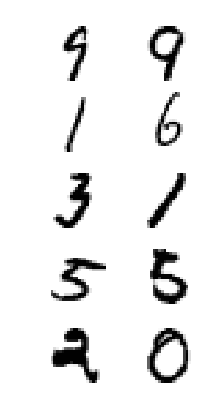

In [224]:
plt.figure(figsize=(3, 3 * batch_size))
plt.subplot(121)
plt.imshow(X_batch[:,0].reshape(28 * batch_size, 28), cmap="binary", interpolation="nearest")
plt.axis('off')
plt.subplot(122)
plt.imshow(X_batch[:,1].reshape(28 * batch_size, 28), cmap="binary", interpolation="nearest")
plt.axis('off')
plt.show()

And let's look at the labels (0 means "different", 1 means "same"):

In [225]:
y_batch

array([[1],
       [0],
       [0],
       [1],
       [0]])

Perfect!

### 10.3.
_Exercise: train the DNN on this training set. For each image pair, you can simultaneously feed the first image to DNN A and the second image to DNN B. The whole network will gradually learn to tell whether two images belong to the same class or not._

Let's generate a test set composed of many pairs of images pulled from the MNIST test set:

In [226]:
X_test1, y_test1 = generate_batch(X_test, y_test, batch_size=len(X_test))

And now, let's train the model. There's really nothing special about this step, except for the fact that we need a fairly large `batch_size`, otherwise the model fails to learn anything and ends up with an accuracy of 50%:

In [227]:
n_epochs = 100
batch_size = 500

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = generate_batch(X_train1, y_train1, batch_size)
            loss_val, _ = sess.run([loss, training_op], feed_dict={X: X_batch, y: y_batch})
        print(epoch, "Train loss:", loss_val)
        if epoch % 5 == 0:
            acc_test = accuracy.eval(feed_dict={X: X_test1, y: y_test1})
            print(epoch, "Test accuracy:", acc_test)

    save_path = saver.save(sess, "./my_digit_comparison_model.ckpt")

0 Train loss: 0.492426
0 Test accuracy: 0.7861
1 Train loss: 0.334813
2 Train loss: 0.290434
3 Train loss: 0.253434
4 Train loss: 0.217843
5 Train loss: 0.17127
5 Test accuracy: 0.9185
6 Train loss: 0.207128
7 Train loss: 0.172275
8 Train loss: 0.166782
9 Train loss: 0.161094
10 Train loss: 0.125131
10 Test accuracy: 0.9425
11 Train loss: 0.159824
12 Train loss: 0.124752
13 Train loss: 0.112234
14 Train loss: 0.114502
15 Train loss: 0.0950093
15 Test accuracy: 0.9532
16 Train loss: 0.119296
17 Train loss: 0.0754429
18 Train loss: 0.112295
19 Train loss: 0.133708
20 Train loss: 0.113547
20 Test accuracy: 0.9596
21 Train loss: 0.0674082
22 Train loss: 0.0936298
23 Train loss: 0.0986469
24 Train loss: 0.111875
25 Train loss: 0.0735622
25 Test accuracy: 0.9675
26 Train loss: 0.0790325
27 Train loss: 0.0487644
28 Train loss: 0.0869071
29 Train loss: 0.0694422
30 Train loss: 0.0600889
30 Test accuracy: 0.9663
31 Train loss: 0.103903
32 Train loss: 0.0535952
33 Train loss: 0.0310679
34 Train 

All right, we reach 97.6% accuracy on this digit comparison task. That's not too bad, this model knows a thing or two about comparing handwritten digits!

Let's see if some of that knowledge can be useful for the regular MNIST classification task.

### 10.4.
_Exercise: now create a new DNN by reusing and freezing the hidden layers of DNN A and adding a softmax output layer on top with 10 neurons. Train this network on split #2 and see if you can achieve high performance despite having only 500 images per class._

Let's create the model, it is pretty straightforward. There are many ways to freeze the lower layers, as explained in the book. In this example, we chose to use the `tf.stop_gradient()` function. Note that we need one `Saver` to restore the pretrained DNN A, and another `Saver` to save the final model: 

In [228]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

dnn_outputs = dnn(X, name="DNN_A")
frozen_outputs = tf.stop_gradient(dnn_outputs)

logits = tf.layers.dense(dnn_outputs, n_outputs, kernel_initializer=he_init)
Y_proba = tf.nn.softmax(logits)

xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy, name="loss")

optimizer = tf.train.MomentumOptimizer(learning_rate, momentum, use_nesterov=True)
training_op = optimizer.minimize(loss)

correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

dnn_A_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="DNN_A")
restore_saver = tf.train.Saver(var_list={var.op.name: var for var in dnn_A_vars})
saver = tf.train.Saver()

Now on to training! We first initialize all variables (including the variables in the new output layer), then we restore the pretrained DNN A. Next, we just train the model on the small MNIST dataset (containing just 5,000 images):

In [229]:
n_epochs = 100
batch_size = 50

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_digit_comparison_model.ckpt")

    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if epoch % 10 == 0:
            acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
            print(epoch, "Test accuracy:", acc_test)

    save_path = saver.save(sess, "./my_mnist_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_digit_comparison_model.ckpt
0 Test accuracy: 0.9269
10 Test accuracy: 0.9665
20 Test accuracy: 0.9671
30 Test accuracy: 0.967
40 Test accuracy: 0.9673
50 Test accuracy: 0.9675
60 Test accuracy: 0.9676
70 Test accuracy: 0.9676
80 Test accuracy: 0.9677
90 Test accuracy: 0.9675


Well, 96.7% accuracy, that's not the best MNIST model we have trained so far, but recall that we are only using a small training set (just 500 images per digit). Let's compare this result with the same DNN trained from scratch, without using transfer learning:

In [230]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

dnn_outputs = dnn(X, name="DNN_A")

logits = tf.layers.dense(dnn_outputs, n_outputs, kernel_initializer=he_init)
Y_proba = tf.nn.softmax(logits)

xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy, name="loss")

optimizer = tf.train.MomentumOptimizer(learning_rate, momentum, use_nesterov=True)
training_op = optimizer.minimize(loss)

correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

dnn_A_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="DNN_A")
restore_saver = tf.train.Saver(var_list={var.op.name: var for var in dnn_A_vars})
saver = tf.train.Saver()

In [231]:
n_epochs = 150
batch_size = 50

with tf.Session() as sess:
    init.run()

    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if epoch % 10 == 0:
            acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
            print(epoch, "Test accuracy:", acc_test)

    save_path = saver.save(sess, "./my_mnist_model_final.ckpt")

0 Test accuracy: 0.8893
10 Test accuracy: 0.9402
20 Test accuracy: 0.9474
30 Test accuracy: 0.9475
40 Test accuracy: 0.9472
50 Test accuracy: 0.9471
60 Test accuracy: 0.9474
70 Test accuracy: 0.9473
80 Test accuracy: 0.9475
90 Test accuracy: 0.9474
100 Test accuracy: 0.9475
110 Test accuracy: 0.9475
120 Test accuracy: 0.9476
130 Test accuracy: 0.9477
140 Test accuracy: 0.9476


Only 94.8% accuracy... So transfer learning helped us reduce the error rate from 5.2% to 3.3% (that's over 36% error reduction). Moreover, the model using transfer learning reached over 96% accuracy in less than 10 epochs.

Bottom line: transfer learning does not always work (as we saw in exercise 9), but when it does it can make a big difference. So try it out!